# Imports

In [1]:
import pickle
import torch
import random
import math
import os
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as T
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

File Loading

In [2]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['image'])
    train_labels = np.array(train_file['controls'])

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['image'])
    val_labels = np.array(val_file['controls'])

Dataset Mean/Std

In [3]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      nimages += batch.size(0)
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

Data Augmentation

In [4]:
# from: https://github.com/TheRoboticsClub/gsoc2023-Meiqi_Zhao/tree/main
class ShiftAndAdjustSteer(object):
    def __init__(self, shift_fraction=0.1, steer_adjust=1.0, p=0.5):
        self.shift_fraction = shift_fraction
        self.steer_adjust = steer_adjust
        self.p = p

    def __call__(self, image, output):
        if random.random() < self.p:
            # sample a random shift
            max_shift_px = self.shift_fraction * image.shape[2]
            shift_px = torch.tensor([random.uniform(-max_shift_px, max_shift_px), 0])

            # apply the shift to the images
            shifted_img = T.affine(image, angle=0, translate=shift_px.tolist(), scale=1, shear=0, interpolation=T.InterpolationMode.NEAREST)

            # adjust the steering angle according to the shift
            shift_fraction = shift_px[0] / image.shape[2]
            shifted_steer = output[0] + self.steer_adjust * shift_fraction
            shifted_steer = torch.clamp(shifted_steer, -1.0, 1.0)

            image = shifted_img
            output[0] = shifted_steer

        return image, output

class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

Data Preprocessing

In [26]:
class AVDataset(Dataset):
    def __init__(self, input_images, control_values, resize, transform):
        self.input_images = input_images
        self.control_values = control_values
        self.resize = resize
        self.transform = transform

    def __len__(self):
        return len(self.control_values)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        control_value = self.control_values[idx]

        input_image = torch.tensor(input_image).permute(2, 0, 1)

        if self.resize:
            input_image = T.resize(input_image, (52, 112))

        if self.transform:
            input_image, control_value = ShiftAndAdjustSteer(shift_fraction=0.15, steer_adjust=1.0, p=0.5)(input_image, control_value)
            input_image = v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=None, hue=None)(input_image)
            input_image = v2.RandomApply(torch.nn.ModuleList([v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.)),]), p=0.5)(input_image)

        input_image = input_image / 255.0
        input_image = v2.Normalize(mean=(0.6651, 0.6439, 0.6236,), std=(0.1352, 0.1353, 0.1364,))(input_image)
        control_value = torch.tensor([(control_value[0]+ 1.0) / 2.0, (control_value[1] - control_value[2] + 1.0) / 2.0])

        return input_image, control_value

train_dataset = AVDataset(input_images=train_data, control_values=train_labels, resize=False, transform=True)
val_dataset = AVDataset(input_images=val_data, control_values=val_labels, resize=False, transform=False)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


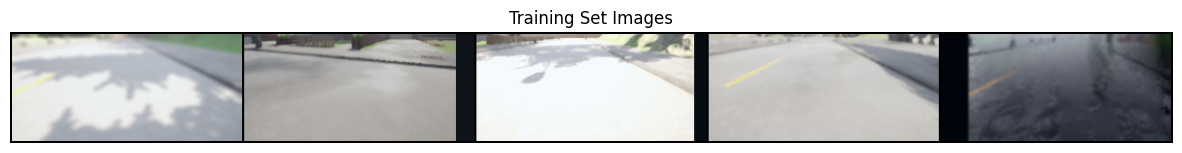

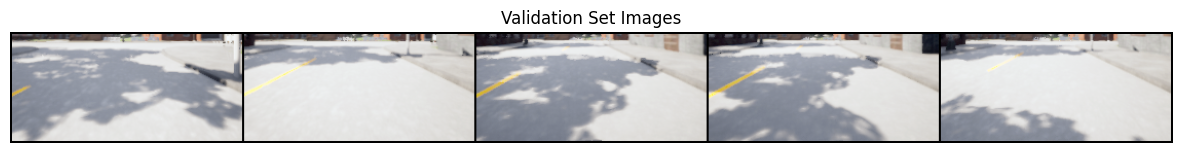

In [27]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Positional Encoding

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=4, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=4, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

AV Model

In [35]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, bias=False),
            nn.SELU(),
        )

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=16, out_channels=16, kernel_size=3, num_layers=2, pool=True, short=True),
            ResidualBlock(in_channels=16, out_channels=32, kernel_size=3, num_layers=2, pool=True, short=True),
            ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, num_layers=2, pool=True, short=True),
            nn.Dropout2d(0.2),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(64, 50, bias=False),
            nn.SELU(),
            nn.Linear(50, 10, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = self.dense_layers(x)
        x = self.output_layer(x)
        out = torch.sigmoid(x)
        return out

# Util

MFPE Loss

In [36]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [37]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [38]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [39]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training

Training Loop

In [43]:
def train_loop(train_loader, model, criterion, optimizer, autoclipper, device, verbose=True):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.float().to(device)
        targets = targets.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        autoclipper(model)
        optimizer.step()

        train_loss += loss.item()
        if (batch + 1) % 100 == 0 and verbose:
            loss, current = train_loss / (batch + 1), (batch + 1) * batch_size
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss

Validation Loop

In [42]:
def val_loop(val_loader, model, criterion, device, verbose=False):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

            if (batch + 1) % 50 == 0 and verbose:
                print(f"Val Batch {batch + 1}")
                print(f"Outputs: {outputs[:3]})")
                print(f"Targets: {targets[:3]})")

    val_loss = val_loss / num_batches
    return val_loss

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
start_epoch = 0
num_epochs = 100
learning_rate = 1e-3

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=5)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []

print(summary(model, input_size=(batch_size, 3, 104, 224)))

# checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_6.pt'
# if os.path.isfile(checkpoint_path):
#     model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, autoclipper, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()
    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses)

Layer (type:depth-idx)                        Output Shape              Param #
AVModel                                       [32, 2]                   --
├─Sequential: 1-1                             [32, 16, 100, 220]        --
│    └─Conv2d: 2-1                            [32, 16, 100, 220]        1,200
│    └─SELU: 2-2                              [32, 16, 100, 220]        --
├─Sequential: 1-2                             [32, 64, 2, 4]            --
│    └─ResidualBlock: 2-3                     [32, 16, 25, 55]          --
│    │    └─Sequential: 3-1                   [32, 16, 100, 220]        400
│    │    └─Sequential: 3-2                   [32, 16, 100, 220]        400
│    │    └─MaxPool2d: 3-3                    [32, 16, 25, 55]          --
│    │    └─Conv2d: 3-4                       [32, 16, 25, 55]          256
│    │    └─SELU: 3-5                         [32, 16, 25, 55]          --
│    └─ResidualBlock: 2-4                     [32, 32, 7, 14]           --
│    │    └─Se

  0%|          | 0/1570 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  6%|▋         | 101/1570 [00:08<01:58, 12.40it/s]

Training loss: 0.037338  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:44, 13.10it/s]

Training loss: 0.037256  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:48, 11.72it/s]

Training loss: 0.037298  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:31, 12.82it/s]

Training loss: 0.037007  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:22, 13.01it/s]

Training loss: 0.036818  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:15, 12.85it/s]

Training loss: 0.036748  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:06, 13.05it/s]

Training loss: 0.036782  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:59, 13.01it/s]

Training loss: 0.036578  [25600/50232]


 57%|█████▋    | 901/1570 [01:10<00:49, 13.44it/s]

Training loss: 0.036375  [28800/50232]


 64%|██████▍   | 1001/1570 [01:18<00:46, 12.27it/s]

Training loss: 0.036323  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:36, 12.89it/s]

Training loss: 0.036232  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:28, 13.14it/s]

Training loss: 0.036121  [38400/50232]


 83%|████████▎ | 1301/1570 [01:42<00:20, 13.08it/s]

Training loss: 0.035978  [41600/50232]


 89%|████████▉ | 1401/1570 [01:49<00:14, 11.93it/s]

Training loss: 0.035929  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 11.84it/s]

Training loss: 0.035901  [48000/50232]


100%|██████████| 1570/1570 [02:03<00:00, 12.66it/s]


Train loss: 0.035827 - Val loss: 0.032211 

Last learning rate: [0.001]
Epoch 2
-------------------------------


  6%|▋         | 102/1570 [00:08<01:58, 12.41it/s]

Training loss: 0.035182  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:46, 12.88it/s]

Training loss: 0.035284  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:41, 12.47it/s]

Training loss: 0.035123  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:30, 12.89it/s]

Training loss: 0.035224  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:30, 11.86it/s]

Training loss: 0.034943  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:16, 12.61it/s]

Training loss: 0.034870  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:08, 12.59it/s]

Training loss: 0.034987  [22400/50232]


 51%|█████     | 802/1570 [01:05<01:01, 12.52it/s]

Training loss: 0.035073  [25600/50232]


 57%|█████▋    | 902/1570 [01:13<00:54, 12.26it/s]

Training loss: 0.035010  [28800/50232]


 64%|██████▍   | 1002/1570 [01:20<00:44, 12.87it/s]

Training loss: 0.034965  [32000/50232]


 70%|███████   | 1102/1570 [01:28<00:36, 12.91it/s]

Training loss: 0.034952  [35200/50232]


 77%|███████▋  | 1202/1570 [01:36<00:29, 12.53it/s]

Training loss: 0.034896  [38400/50232]


 83%|████████▎ | 1302/1570 [01:44<00:22, 11.90it/s]

Training loss: 0.034877  [41600/50232]


 89%|████████▉ | 1402/1570 [01:52<00:13, 12.46it/s]

Training loss: 0.034848  [44800/50232]


 96%|█████████▌| 1502/1570 [02:00<00:05, 12.16it/s]

Training loss: 0.034825  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.42it/s]


Train loss: 0.034817 - Val loss: 0.032133 

Last learning rate: [0.0009997532801828658]
Epoch 3
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.88it/s]

Training loss: 0.034862  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.38it/s]

Training loss: 0.034229  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:54, 11.11it/s]

Training loss: 0.034705  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:40, 11.61it/s]

Training loss: 0.034685  [12800/50232]


 32%|███▏      | 501/1570 [00:42<01:33, 11.38it/s]

Training loss: 0.034745  [16000/50232]


 38%|███▊      | 601/1570 [00:50<01:17, 12.48it/s]

Training loss: 0.034650  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:07, 12.87it/s]

Training loss: 0.034547  [22400/50232]


 51%|█████     | 801/1570 [01:06<00:59, 12.94it/s]

Training loss: 0.034443  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:54, 12.38it/s]

Training loss: 0.034407  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:44, 12.68it/s]

Training loss: 0.034319  [32000/50232]


 70%|███████   | 1101/1570 [01:30<00:37, 12.61it/s]

Training loss: 0.034366  [35200/50232]


 76%|███████▋  | 1201/1570 [01:38<00:31, 11.64it/s]

Training loss: 0.034385  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:21, 12.54it/s]

Training loss: 0.034401  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:13, 12.31it/s]

Training loss: 0.034434  [44800/50232]


 96%|█████████▌| 1501/1570 [02:03<00:05, 11.84it/s]

Training loss: 0.034501  [48000/50232]


100%|██████████| 1570/1570 [02:09<00:00, 12.15it/s]


Train loss: 0.034513 - Val loss: 0.031942 

Last learning rate: [0.0009990133642141358]
Epoch 4
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.04it/s]

Training loss: 0.034049  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.88it/s]

Training loss: 0.033860  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:46, 11.88it/s]

Training loss: 0.034064  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.75it/s]

Training loss: 0.034215  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:30, 11.86it/s]

Training loss: 0.034144  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 12.05it/s]

Training loss: 0.034079  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:06, 13.07it/s]

Training loss: 0.034165  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:02, 12.23it/s]

Training loss: 0.034215  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:57, 11.71it/s]

Training loss: 0.034250  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:46, 12.26it/s]

Training loss: 0.034324  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:38, 12.18it/s]

Training loss: 0.034343  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:31, 11.85it/s]

Training loss: 0.034329  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:21, 12.69it/s]

Training loss: 0.034311  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:14, 12.02it/s]

Training loss: 0.034324  [44800/50232]


 96%|█████████▌| 1501/1570 [02:03<00:05, 11.51it/s]

Training loss: 0.034373  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.19it/s]


Train loss: 0.034389 - Val loss: 0.032066 

Last learning rate: [0.00099778098230154]
Epoch 5
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.34it/s]

Training loss: 0.033371  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.44it/s]

Training loss: 0.033606  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:41, 12.54it/s]

Training loss: 0.034042  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.83it/s]

Training loss: 0.034087  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:19, 13.41it/s]

Training loss: 0.034015  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:15, 12.81it/s]

Training loss: 0.034096  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:09, 12.46it/s]

Training loss: 0.034153  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:00, 12.64it/s]

Training loss: 0.034045  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:55, 12.09it/s]

Training loss: 0.034015  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.41it/s]

Training loss: 0.034095  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.84it/s]

Training loss: 0.034122  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:32, 11.46it/s]

Training loss: 0.034070  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.25it/s]

Training loss: 0.034196  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.37it/s]

Training loss: 0.034209  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 11.85it/s]

Training loss: 0.034195  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.35it/s]


Train loss: 0.034230 - Val loss: 0.031457 

Last learning rate: [0.000996057350657239]
Epoch 6
-------------------------------


  6%|▋         | 101/1570 [00:08<02:02, 11.97it/s]

Training loss: 0.034588  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.42it/s]

Training loss: 0.034383  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:58, 10.74it/s]

Training loss: 0.034348  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:32, 12.62it/s]

Training loss: 0.034405  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:25, 12.54it/s]

Training loss: 0.034495  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:23, 11.59it/s]

Training loss: 0.034333  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:14, 11.68it/s]

Training loss: 0.034268  [22400/50232]


 51%|█████     | 801/1570 [01:07<01:05, 11.80it/s]

Training loss: 0.034176  [25600/50232]


 57%|█████▋    | 901/1570 [01:15<00:53, 12.50it/s]

Training loss: 0.034058  [28800/50232]


 64%|██████▍   | 1001/1570 [01:24<00:50, 11.22it/s]

Training loss: 0.034167  [32000/50232]


 70%|███████   | 1101/1570 [01:33<00:41, 11.29it/s]

Training loss: 0.034134  [35200/50232]


 76%|███████▋  | 1201/1570 [01:41<00:30, 12.09it/s]

Training loss: 0.034130  [38400/50232]


 83%|████████▎ | 1301/1570 [01:49<00:22, 12.12it/s]

Training loss: 0.034033  [41600/50232]


 89%|████████▉ | 1401/1570 [01:58<00:14, 11.78it/s]

Training loss: 0.034034  [44800/50232]


 96%|█████████▌| 1501/1570 [02:06<00:06, 11.40it/s]

Training loss: 0.034075  [48000/50232]


100%|██████████| 1570/1570 [02:12<00:00, 11.85it/s]


Train loss: 0.034062 - Val loss: 0.030921 

Last learning rate: [0.0009938441702975688]
Epoch 7
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.93it/s]

Training loss: 0.034138  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:53, 12.04it/s]

Training loss: 0.033764  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:45, 12.04it/s]

Training loss: 0.033709  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:40, 11.63it/s]

Training loss: 0.033904  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:30, 11.81it/s]

Training loss: 0.034040  [16000/50232]


 38%|███▊      | 601/1570 [00:50<01:19, 12.14it/s]

Training loss: 0.034142  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:12, 12.05it/s]

Training loss: 0.034151  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:01, 12.41it/s]

Training loss: 0.034145  [25600/50232]


 57%|█████▋    | 901/1570 [01:15<00:57, 11.73it/s]

Training loss: 0.034011  [28800/50232]


 64%|██████▍   | 1001/1570 [01:23<00:48, 11.71it/s]

Training loss: 0.034010  [32000/50232]


 70%|███████   | 1101/1570 [01:32<00:40, 11.72it/s]

Training loss: 0.033943  [35200/50232]


 76%|███████▋  | 1201/1570 [01:40<00:31, 11.77it/s]

Training loss: 0.033981  [38400/50232]


 83%|████████▎ | 1301/1570 [01:49<00:21, 12.45it/s]

Training loss: 0.033989  [41600/50232]


 89%|████████▉ | 1401/1570 [01:57<00:13, 12.17it/s]

Training loss: 0.033961  [44800/50232]


 96%|█████████▌| 1501/1570 [02:05<00:05, 12.02it/s]

Training loss: 0.033939  [48000/50232]


100%|██████████| 1570/1570 [02:11<00:00, 11.93it/s]


Train loss: 0.033935 - Val loss: 0.031146 

Last learning rate: [0.0009911436253643444]
Epoch 8
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.29it/s]

Training loss: 0.033139  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:56, 11.77it/s]

Training loss: 0.033395  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:44, 12.16it/s]

Training loss: 0.033778  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:33, 12.45it/s]

Training loss: 0.033881  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:36, 11.08it/s]

Training loss: 0.033672  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:23, 11.67it/s]

Training loss: 0.033743  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:11, 12.12it/s]

Training loss: 0.033686  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:08, 11.25it/s]

Training loss: 0.033690  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:57, 11.70it/s]

Training loss: 0.033737  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:45, 12.44it/s]

Training loss: 0.033701  [32000/50232]


 70%|███████   | 1101/1570 [01:30<00:37, 12.41it/s]

Training loss: 0.033686  [35200/50232]


 76%|███████▋  | 1201/1570 [01:38<00:29, 12.65it/s]

Training loss: 0.033702  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:21, 12.70it/s]

Training loss: 0.033727  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:13, 12.62it/s]

Training loss: 0.033843  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 12.61it/s]

Training loss: 0.033856  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.21it/s]


Train loss: 0.033856 - Val loss: 0.030699 

Last learning rate: [0.0009879583809693736]
Epoch 9
-------------------------------


  6%|▋         | 101/1570 [00:08<02:07, 11.54it/s]

Training loss: 0.033621  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:51, 12.30it/s]

Training loss: 0.033658  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.63it/s]

Training loss: 0.033923  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:42, 11.43it/s]

Training loss: 0.033922  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:31, 11.68it/s]

Training loss: 0.034139  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:16, 12.64it/s]

Training loss: 0.034102  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:12, 12.01it/s]

Training loss: 0.034018  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:09, 11.00it/s]

Training loss: 0.033926  [25600/50232]


 57%|█████▋    | 901/1570 [01:15<00:52, 12.72it/s]

Training loss: 0.033787  [28800/50232]


 64%|██████▍   | 1001/1570 [01:23<00:47, 12.04it/s]

Training loss: 0.033817  [32000/50232]


 70%|███████   | 1101/1570 [01:31<00:42, 11.14it/s]

Training loss: 0.033787  [35200/50232]


 76%|███████▋  | 1201/1570 [01:39<00:28, 12.78it/s]

Training loss: 0.033819  [38400/50232]


 83%|████████▎ | 1301/1570 [01:47<00:21, 12.23it/s]

Training loss: 0.033749  [41600/50232]


 89%|████████▉ | 1401/1570 [01:55<00:14, 11.48it/s]

Training loss: 0.033729  [44800/50232]


 96%|█████████▌| 1501/1570 [02:04<00:05, 12.50it/s]

Training loss: 0.033765  [48000/50232]


100%|██████████| 1570/1570 [02:09<00:00, 12.10it/s]


Train loss: 0.033765 - Val loss: 0.030653 

Last learning rate: [0.0009842915805643154]
Epoch 10
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.48it/s]

Training loss: 0.033962  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<02:01, 11.29it/s]

Training loss: 0.033311  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:41, 12.45it/s]

Training loss: 0.033555  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:37, 12.02it/s]

Training loss: 0.033695  [12800/50232]


 32%|███▏      | 501/1570 [00:42<01:28, 12.04it/s]

Training loss: 0.033738  [16000/50232]


 38%|███▊      | 601/1570 [00:50<01:16, 12.59it/s]

Training loss: 0.033733  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:15, 11.59it/s]

Training loss: 0.033768  [22400/50232]


 51%|█████     | 801/1570 [01:07<01:09, 11.13it/s]

Training loss: 0.033702  [25600/50232]


 57%|█████▋    | 901/1570 [01:16<00:55, 12.07it/s]

Training loss: 0.033629  [28800/50232]


 64%|██████▍   | 1001/1570 [01:24<00:47, 11.88it/s]

Training loss: 0.033609  [32000/50232]


 70%|███████   | 1101/1570 [01:32<00:40, 11.64it/s]

Training loss: 0.033637  [35200/50232]


 76%|███████▋  | 1201/1570 [01:41<00:30, 12.26it/s]

Training loss: 0.033682  [38400/50232]


 83%|████████▎ | 1301/1570 [01:49<00:21, 12.46it/s]

Training loss: 0.033680  [41600/50232]


 89%|████████▉ | 1401/1570 [01:57<00:15, 11.24it/s]

Training loss: 0.033725  [44800/50232]


 96%|█████████▌| 1501/1570 [02:05<00:05, 12.14it/s]

Training loss: 0.033737  [48000/50232]


100%|██████████| 1570/1570 [02:11<00:00, 11.92it/s]


Train loss: 0.033692 - Val loss: 0.030495 

Last learning rate: [0.0009801468428384714]
Epoch 11
-------------------------------


  6%|▋         | 101/1570 [00:08<01:53, 12.89it/s]

Training loss: 0.033357  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:49, 12.49it/s]

Training loss: 0.033714  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:41, 12.46it/s]

Training loss: 0.033516  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.39it/s]

Training loss: 0.033672  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:30, 11.85it/s]

Training loss: 0.033566  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:20, 12.02it/s]

Training loss: 0.033690  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:12, 11.92it/s]

Training loss: 0.033681  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:03, 12.15it/s]

Training loss: 0.033644  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:56, 11.76it/s]

Training loss: 0.033681  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:44, 12.67it/s]

Training loss: 0.033692  [32000/50232]


 70%|███████   | 1101/1570 [01:31<00:41, 11.42it/s]

Training loss: 0.033633  [35200/50232]


 76%|███████▋  | 1201/1570 [01:39<00:32, 11.39it/s]

Training loss: 0.033656  [38400/50232]


 83%|████████▎ | 1301/1570 [01:47<00:21, 12.40it/s]

Training loss: 0.033717  [41600/50232]


 89%|████████▉ | 1401/1570 [01:56<00:14, 11.64it/s]

Training loss: 0.033708  [44800/50232]


 96%|█████████▌| 1501/1570 [02:04<00:05, 12.04it/s]

Training loss: 0.033691  [48000/50232]


100%|██████████| 1570/1570 [02:09<00:00, 12.08it/s]


Train loss: 0.033660 - Val loss: 0.030192 

Last learning rate: [0.0009755282581475767]
Epoch 12
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.17it/s]

Training loss: 0.032902  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:56, 11.79it/s]

Training loss: 0.032695  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:50, 11.52it/s]

Training loss: 0.032897  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:37, 12.02it/s]

Training loss: 0.033087  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:33, 11.41it/s]

Training loss: 0.033359  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:20, 12.07it/s]

Training loss: 0.033566  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:08, 12.69it/s]

Training loss: 0.033575  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:03, 12.02it/s]

Training loss: 0.033541  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:55, 12.03it/s]

Training loss: 0.033613  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:45, 12.58it/s]

Training loss: 0.033682  [32000/50232]


 70%|███████   | 1101/1570 [01:30<00:39, 11.77it/s]

Training loss: 0.033655  [35200/50232]


 76%|███████▋  | 1201/1570 [01:38<00:30, 12.04it/s]

Training loss: 0.033654  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:22, 12.09it/s]

Training loss: 0.033688  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:14, 11.94it/s]

Training loss: 0.033686  [44800/50232]


 96%|█████████▌| 1501/1570 [02:03<00:05, 11.61it/s]

Training loss: 0.033641  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.20it/s]


Train loss: 0.033625 - Val loss: 0.030191 

Last learning rate: [0.0009704403844771127]
Epoch 13
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.45it/s]

Training loss: 0.032614  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:58, 11.57it/s]

Training loss: 0.033073  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:46, 11.88it/s]

Training loss: 0.033620  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:29, 13.00it/s]

Training loss: 0.033542  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:31, 11.74it/s]

Training loss: 0.033756  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:18, 12.27it/s]

Training loss: 0.033680  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:06, 13.11it/s]

Training loss: 0.033734  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:01, 12.51it/s]

Training loss: 0.033650  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:52, 12.63it/s]

Training loss: 0.033627  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:43, 13.21it/s]

Training loss: 0.033653  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:41, 11.33it/s]

Training loss: 0.033620  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:31, 11.82it/s]

Training loss: 0.033517  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:20, 12.83it/s]

Training loss: 0.033619  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.78it/s]

Training loss: 0.033601  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.29it/s]

Training loss: 0.033603  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.32it/s]


Train loss: 0.033574 - Val loss: 0.030544 

Last learning rate: [0.0009648882429441257]
Epoch 14
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.85it/s]

Training loss: 0.033573  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:49, 12.49it/s]

Training loss: 0.033851  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:47, 11.83it/s]

Training loss: 0.033416  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.65it/s]

Training loss: 0.033406  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:29, 11.99it/s]

Training loss: 0.033472  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 12.01it/s]

Training loss: 0.033581  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.72it/s]

Training loss: 0.033483  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:02, 12.23it/s]

Training loss: 0.033531  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:53, 12.45it/s]

Training loss: 0.033493  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:43, 13.08it/s]

Training loss: 0.033496  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:37, 12.50it/s]

Training loss: 0.033433  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:29, 12.65it/s]

Training loss: 0.033433  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:20, 12.98it/s]

Training loss: 0.033435  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.45it/s]

Training loss: 0.033506  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.35it/s]

Training loss: 0.033508  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.37it/s]


Train loss: 0.033550 - Val loss: 0.030306 

Last learning rate: [0.0009588773128419905]
Epoch 15
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.28it/s]

Training loss: 0.033371  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:56, 11.76it/s]

Training loss: 0.033407  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:47, 11.80it/s]

Training loss: 0.033498  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:34, 12.39it/s]

Training loss: 0.033430  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:30, 11.76it/s]

Training loss: 0.033578  [16000/50232]


 38%|███▊      | 601/1570 [00:50<01:19, 12.15it/s]

Training loss: 0.033633  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:14, 11.69it/s]

Training loss: 0.033521  [22400/50232]


 51%|█████     | 801/1570 [01:07<01:00, 12.62it/s]

Training loss: 0.033584  [25600/50232]


 57%|█████▋    | 901/1570 [01:15<00:53, 12.61it/s]

Training loss: 0.033566  [28800/50232]


 64%|██████▍   | 1001/1570 [01:23<00:45, 12.48it/s]

Training loss: 0.033557  [32000/50232]


 70%|███████   | 1101/1570 [01:31<00:37, 12.54it/s]

Training loss: 0.033507  [35200/50232]


 76%|███████▋  | 1201/1570 [01:39<00:29, 12.65it/s]

Training loss: 0.033420  [38400/50232]


 83%|████████▎ | 1301/1570 [01:47<00:21, 12.32it/s]

Training loss: 0.033441  [41600/50232]


 89%|████████▉ | 1401/1570 [01:55<00:14, 11.85it/s]

Training loss: 0.033440  [44800/50232]


 96%|█████████▌| 1501/1570 [02:03<00:05, 12.72it/s]

Training loss: 0.033461  [48000/50232]


100%|██████████| 1570/1570 [02:09<00:00, 12.12it/s]


Train loss: 0.033468 - Val loss: 0.030416 

Last learning rate: [0.0009524135262330098]
Epoch 16
-------------------------------


  6%|▋         | 102/1570 [00:09<02:01, 12.11it/s]

Training loss: 0.033653  [ 3200/50232]


 13%|█▎        | 202/1570 [00:17<01:53, 12.08it/s]

Training loss: 0.034009  [ 6400/50232]


 19%|█▉        | 302/1570 [00:26<01:52, 11.25it/s]

Training loss: 0.034078  [ 9600/50232]


 26%|██▌       | 402/1570 [00:34<01:36, 12.10it/s]

Training loss: 0.033781  [12800/50232]


 32%|███▏      | 502/1570 [00:43<01:29, 11.94it/s]

Training loss: 0.033515  [16000/50232]


 38%|███▊      | 602/1570 [00:51<01:26, 11.24it/s]

Training loss: 0.033590  [19200/50232]


 45%|████▍     | 702/1570 [00:59<01:12, 11.92it/s]

Training loss: 0.033482  [22400/50232]


 51%|█████     | 802/1570 [01:08<01:02, 12.30it/s]

Training loss: 0.033404  [25600/50232]


 57%|█████▋    | 902/1570 [01:16<00:55, 12.13it/s]

Training loss: 0.033285  [28800/50232]


 64%|██████▍   | 1002/1570 [01:24<00:46, 12.09it/s]

Training loss: 0.033280  [32000/50232]


 70%|███████   | 1102/1570 [01:33<00:37, 12.61it/s]

Training loss: 0.033252  [35200/50232]


 77%|███████▋  | 1202/1570 [01:41<00:28, 12.72it/s]

Training loss: 0.033333  [38400/50232]


 83%|████████▎ | 1302/1570 [01:49<00:22, 12.11it/s]

Training loss: 0.033382  [41600/50232]


 89%|████████▉ | 1402/1570 [01:57<00:13, 12.18it/s]

Training loss: 0.033371  [44800/50232]


 96%|█████████▌| 1502/1570 [02:05<00:05, 12.12it/s]

Training loss: 0.033397  [48000/50232]


100%|██████████| 1570/1570 [02:10<00:00, 12.04it/s]


Train loss: 0.033444 - Val loss: 0.030505 

Last learning rate: [0.0009455032620941839]
Epoch 17
-------------------------------


  6%|▋         | 101/1570 [00:08<02:02, 11.95it/s]

Training loss: 0.032731  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:53, 12.11it/s]

Training loss: 0.033243  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:36, 13.12it/s]

Training loss: 0.033133  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.37it/s]

Training loss: 0.033063  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:28, 12.06it/s]

Training loss: 0.033246  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:21, 11.96it/s]

Training loss: 0.033141  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:15, 11.54it/s]

Training loss: 0.033176  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:03, 12.17it/s]

Training loss: 0.033154  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:53, 12.58it/s]

Training loss: 0.033247  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:51, 10.95it/s]

Training loss: 0.033303  [32000/50232]


 70%|███████   | 1101/1570 [01:30<00:40, 11.66it/s]

Training loss: 0.033408  [35200/50232]


 76%|███████▋  | 1201/1570 [01:38<00:29, 12.53it/s]

Training loss: 0.033466  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:22, 12.01it/s]

Training loss: 0.033450  [41600/50232]


 89%|████████▉ | 1401/1570 [01:55<00:13, 12.63it/s]

Training loss: 0.033392  [44800/50232]


 96%|█████████▌| 1501/1570 [02:03<00:05, 12.57it/s]

Training loss: 0.033457  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.18it/s]


Train loss: 0.033450 - Val loss: 0.030879 

Last learning rate: [0.0009381533400219318]
Epoch 18
-------------------------------


  6%|▋         | 101/1570 [00:08<01:55, 12.72it/s]

Training loss: 0.033668  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.41it/s]

Training loss: 0.033894  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.66it/s]

Training loss: 0.033445  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:34, 12.32it/s]

Training loss: 0.033362  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:36, 11.02it/s]

Training loss: 0.033371  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:13, 13.20it/s]

Training loss: 0.033268  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:09, 12.47it/s]

Training loss: 0.033425  [22400/50232]


 51%|█████     | 801/1570 [01:05<00:59, 13.00it/s]

Training loss: 0.033479  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:53, 12.46it/s]

Training loss: 0.033496  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:47, 11.95it/s]

Training loss: 0.033500  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:38, 12.06it/s]

Training loss: 0.033444  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:28, 12.76it/s]

Training loss: 0.033456  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.45it/s]

Training loss: 0.033449  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.65it/s]

Training loss: 0.033467  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 12.90it/s]

Training loss: 0.033428  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.29it/s]


Train loss: 0.033398 - Val loss: 0.030615 

Last learning rate: [0.0009303710135019719]
Epoch 19
-------------------------------


  6%|▋         | 101/1570 [00:08<01:56, 12.66it/s]

Training loss: 0.032909  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:54, 11.91it/s]

Training loss: 0.032934  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:44, 12.18it/s]

Training loss: 0.033069  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:35, 12.23it/s]

Training loss: 0.033228  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:30, 11.79it/s]

Training loss: 0.033070  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:13, 13.27it/s]

Training loss: 0.033149  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:08, 12.73it/s]

Training loss: 0.033171  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:03, 12.10it/s]

Training loss: 0.033180  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:52, 12.66it/s]

Training loss: 0.033185  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:44, 12.75it/s]

Training loss: 0.033189  [32000/50232]


 70%|███████   | 1101/1570 [01:30<00:38, 12.21it/s]

Training loss: 0.033224  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:28, 12.78it/s]

Training loss: 0.033253  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:20, 12.83it/s]

Training loss: 0.033308  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:14, 12.04it/s]

Training loss: 0.033323  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 12.19it/s]

Training loss: 0.033336  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.22it/s]


Train loss: 0.033355 - Val loss: 0.031021 

Last learning rate: [0.0009221639627510076]
Epoch 20
-------------------------------


  6%|▋         | 101/1570 [00:08<01:55, 12.73it/s]

Training loss: 0.033198  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:54, 11.96it/s]

Training loss: 0.033148  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:49, 11.64it/s]

Training loss: 0.033242  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:33, 12.55it/s]

Training loss: 0.033371  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:36, 11.11it/s]

Training loss: 0.033295  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:22, 11.71it/s]

Training loss: 0.033144  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:12, 12.01it/s]

Training loss: 0.033123  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:07, 11.36it/s]

Training loss: 0.033130  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:55, 12.08it/s]

Training loss: 0.033176  [28800/50232]


 64%|██████▍   | 1001/1570 [01:23<00:45, 12.41it/s]

Training loss: 0.033204  [32000/50232]


 70%|███████   | 1101/1570 [01:31<00:38, 12.10it/s]

Training loss: 0.033289  [35200/50232]


 76%|███████▋  | 1201/1570 [01:39<00:31, 11.90it/s]

Training loss: 0.033297  [38400/50232]


 83%|████████▎ | 1301/1570 [01:48<00:21, 12.46it/s]

Training loss: 0.033353  [41600/50232]


 89%|████████▉ | 1401/1570 [01:56<00:13, 12.11it/s]

Training loss: 0.033406  [44800/50232]


 96%|█████████▌| 1501/1570 [02:04<00:05, 11.66it/s]

Training loss: 0.033448  [48000/50232]


100%|██████████| 1570/1570 [02:10<00:00, 12.00it/s]


Train loss: 0.033381 - Val loss: 0.031081 

Last learning rate: [0.000913540287137281]
Epoch 21
-------------------------------


  6%|▋         | 101/1570 [00:08<02:04, 11.77it/s]

Training loss: 0.032397  [ 3200/50232]


 13%|█▎        | 201/1570 [00:17<02:01, 11.25it/s]

Training loss: 0.032839  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:43, 12.29it/s]

Training loss: 0.033242  [ 9600/50232]


 26%|██▌       | 401/1570 [00:34<01:43, 11.30it/s]

Training loss: 0.033440  [12800/50232]


 32%|███▏      | 501/1570 [00:42<01:32, 11.60it/s]

Training loss: 0.033441  [16000/50232]


 38%|███▊      | 601/1570 [00:51<01:23, 11.62it/s]

Training loss: 0.033452  [19200/50232]


 45%|████▍     | 701/1570 [00:59<01:11, 12.19it/s]

Training loss: 0.033426  [22400/50232]


 51%|█████     | 801/1570 [01:07<01:00, 12.71it/s]

Training loss: 0.033491  [25600/50232]


 57%|█████▋    | 901/1570 [01:16<00:55, 12.02it/s]

Training loss: 0.033290  [28800/50232]


 64%|██████▍   | 1001/1570 [01:24<00:47, 12.02it/s]

Training loss: 0.033314  [32000/50232]


 70%|███████   | 1101/1570 [01:32<00:36, 12.72it/s]

Training loss: 0.033331  [35200/50232]


 76%|███████▋  | 1201/1570 [01:40<00:30, 12.24it/s]

Training loss: 0.033385  [38400/50232]


 83%|████████▎ | 1301/1570 [01:49<00:20, 12.84it/s]

Training loss: 0.033344  [41600/50232]


 89%|████████▉ | 1401/1570 [01:57<00:14, 11.98it/s]

Training loss: 0.033383  [44800/50232]


 96%|█████████▌| 1501/1570 [02:05<00:05, 12.29it/s]

Training loss: 0.033387  [48000/50232]


100%|██████████| 1570/1570 [02:11<00:00, 11.98it/s]


Train loss: 0.033328 - Val loss: 0.030366 

Last learning rate: [0.0009045084971874739]
Epoch 22
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.82it/s]

Training loss: 0.032721  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:56, 11.76it/s]

Training loss: 0.033406  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:44, 12.12it/s]

Training loss: 0.033575  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.62it/s]

Training loss: 0.033584  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.65it/s]

Training loss: 0.033687  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:22, 11.78it/s]

Training loss: 0.033654  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:06, 12.98it/s]

Training loss: 0.033415  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.46it/s]

Training loss: 0.033353  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:59, 11.23it/s]

Training loss: 0.033291  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:47, 12.07it/s]

Training loss: 0.033310  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:36, 12.97it/s]

Training loss: 0.033334  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:32, 11.47it/s]

Training loss: 0.033256  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.24it/s]

Training loss: 0.033237  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.48it/s]

Training loss: 0.033285  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.29it/s]

Training loss: 0.033281  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.34it/s]


Train loss: 0.033305 - Val loss: 0.030531 

Last learning rate: [0.0008950775061878452]
Epoch 23
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.30it/s]

Training loss: 0.032223  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.41it/s]

Training loss: 0.032029  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:40, 12.58it/s]

Training loss: 0.032349  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:39, 11.77it/s]

Training loss: 0.032678  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:23, 12.80it/s]

Training loss: 0.032906  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:18, 12.38it/s]

Training loss: 0.033083  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:06, 13.05it/s]

Training loss: 0.033092  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:04, 11.86it/s]

Training loss: 0.033168  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:56, 11.78it/s]

Training loss: 0.033191  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.32it/s]

Training loss: 0.033266  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:41, 11.42it/s]

Training loss: 0.033402  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:30, 12.22it/s]

Training loss: 0.033374  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.51it/s]

Training loss: 0.033319  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:14, 12.07it/s]

Training loss: 0.033276  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:06, 11.39it/s]

Training loss: 0.033233  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.27it/s]


Train loss: 0.033241 - Val loss: 0.030745 

Last learning rate: [0.0008852566213878947]
Epoch 24
-------------------------------


  6%|▋         | 102/1570 [00:08<01:55, 12.67it/s]

Training loss: 0.033310  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:50, 12.38it/s]

Training loss: 0.033409  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:38, 12.82it/s]

Training loss: 0.033390  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:36, 12.09it/s]

Training loss: 0.033268  [12800/50232]


 32%|███▏      | 502/1570 [00:41<01:27, 12.18it/s]

Training loss: 0.033204  [16000/50232]


 38%|███▊      | 602/1570 [00:49<01:17, 12.54it/s]

Training loss: 0.033170  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:04, 13.42it/s]

Training loss: 0.033163  [22400/50232]


 51%|█████     | 802/1570 [01:05<00:58, 13.17it/s]

Training loss: 0.033133  [25600/50232]


 57%|█████▋    | 902/1570 [01:12<00:50, 13.14it/s]

Training loss: 0.033192  [28800/50232]


 64%|██████▍   | 1002/1570 [01:21<00:44, 12.63it/s]

Training loss: 0.033098  [32000/50232]


 70%|███████   | 1102/1570 [01:28<00:36, 12.95it/s]

Training loss: 0.033122  [35200/50232]


 77%|███████▋  | 1202/1570 [01:36<00:30, 12.00it/s]

Training loss: 0.033158  [38400/50232]


 83%|████████▎ | 1302/1570 [01:44<00:20, 12.98it/s]

Training loss: 0.033162  [41600/50232]


 89%|████████▉ | 1402/1570 [01:52<00:13, 12.69it/s]

Training loss: 0.033204  [44800/50232]


 96%|█████████▌| 1502/1570 [02:00<00:05, 11.47it/s]

Training loss: 0.033208  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.43it/s]


Train loss: 0.033211 - Val loss: 0.031384 

Last learning rate: [0.0008750555348152298]
Epoch 25
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.29it/s]

Training loss: 0.032664  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:57, 11.69it/s]

Training loss: 0.033261  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.59it/s]

Training loss: 0.032894  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.21it/s]

Training loss: 0.032964  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:31, 11.74it/s]

Training loss: 0.033294  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:22, 11.69it/s]

Training loss: 0.033168  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:11, 12.09it/s]

Training loss: 0.033005  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:04, 11.97it/s]

Training loss: 0.033229  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:55, 12.00it/s]

Training loss: 0.033170  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:45, 12.53it/s]

Training loss: 0.033238  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:37, 12.39it/s]

Training loss: 0.033211  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:30, 12.10it/s]

Training loss: 0.033266  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.71it/s]

Training loss: 0.033280  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.09it/s]

Training loss: 0.033303  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.74it/s]

Training loss: 0.033255  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.33it/s]


Train loss: 0.033248 - Val loss: 0.030516 

Last learning rate: [0.0008644843137107057]
Epoch 26
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.33it/s]

Training loss: 0.033334  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:44, 13.13it/s]

Training loss: 0.033435  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:38, 12.90it/s]

Training loss: 0.033519  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:41, 11.53it/s]

Training loss: 0.033477  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.40it/s]

Training loss: 0.033368  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.66it/s]

Training loss: 0.033371  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.63it/s]

Training loss: 0.033405  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.95it/s]

Training loss: 0.033429  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:51, 13.07it/s]

Training loss: 0.033508  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.39it/s]

Training loss: 0.033360  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.32it/s]

Training loss: 0.033266  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:27, 13.23it/s]

Training loss: 0.033158  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.53it/s]

Training loss: 0.033180  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.36it/s]

Training loss: 0.033153  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.90it/s]

Training loss: 0.033111  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.48it/s]


Train loss: 0.033169 - Val loss: 0.030004 

Last learning rate: [0.0008535533905932737]
Epoch 27
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.55it/s]

Training loss: 0.034489  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 12.93it/s]

Training loss: 0.033368  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:36, 13.11it/s]

Training loss: 0.033243  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.59it/s]

Training loss: 0.033145  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:21, 13.18it/s]

Training loss: 0.033194  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:14, 12.95it/s]

Training loss: 0.033234  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:14, 11.61it/s]

Training loss: 0.033059  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.51it/s]

Training loss: 0.033104  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.25it/s]

Training loss: 0.033171  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.57it/s]

Training loss: 0.033080  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.55it/s]

Training loss: 0.033061  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.69it/s]

Training loss: 0.033054  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 13.42it/s]

Training loss: 0.033127  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.88it/s]

Training loss: 0.033177  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.76it/s]

Training loss: 0.033192  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.45it/s]


Train loss: 0.033188 - Val loss: 0.030086 

Last learning rate: [0.0008422735529643444]
Epoch 28
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.20it/s]

Training loss: 0.033196  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:48, 12.63it/s]

Training loss: 0.033016  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:47, 11.83it/s]

Training loss: 0.033266  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:35, 12.28it/s]

Training loss: 0.033088  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:25, 12.56it/s]

Training loss: 0.033050  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:22, 11.76it/s]

Training loss: 0.033079  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.41it/s]

Training loss: 0.033155  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.03it/s]

Training loss: 0.033181  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:57, 11.63it/s]

Training loss: 0.033143  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:48, 11.73it/s]

Training loss: 0.033153  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:40, 11.65it/s]

Training loss: 0.033215  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:32, 11.20it/s]

Training loss: 0.033282  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.26it/s]

Training loss: 0.033200  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.51it/s]

Training loss: 0.033134  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 11.82it/s]

Training loss: 0.033143  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.27it/s]


Train loss: 0.033159 - Val loss: 0.031129 

Last learning rate: [0.0008306559326618259]
Epoch 29
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.19it/s]

Training loss: 0.033857  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.82it/s]

Training loss: 0.033386  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:49, 11.59it/s]

Training loss: 0.033429  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.19it/s]

Training loss: 0.033305  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.38it/s]

Training loss: 0.033212  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:25, 11.29it/s]

Training loss: 0.033107  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:14, 11.73it/s]

Training loss: 0.033175  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:00, 12.73it/s]

Training loss: 0.033124  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:55, 12.08it/s]

Training loss: 0.033085  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:47, 12.07it/s]

Training loss: 0.033023  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:38, 12.29it/s]

Training loss: 0.033033  [35200/50232]


 76%|███████▋  | 1201/1570 [01:38<00:29, 12.62it/s]

Training loss: 0.033079  [38400/50232]


 83%|████████▎ | 1301/1570 [01:46<00:21, 12.45it/s]

Training loss: 0.033075  [41600/50232]


 89%|████████▉ | 1401/1570 [01:54<00:13, 12.57it/s]

Training loss: 0.033049  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 13.10it/s]

Training loss: 0.033105  [48000/50232]


100%|██████████| 1570/1570 [02:08<00:00, 12.25it/s]


Train loss: 0.033127 - Val loss: 0.030432 

Last learning rate: [0.0008187119948743449]
Epoch 30
-------------------------------


  6%|▋         | 101/1570 [00:08<01:55, 12.69it/s]

Training loss: 0.032325  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:55, 11.87it/s]

Training loss: 0.033196  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:49, 11.60it/s]

Training loss: 0.033174  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:33, 12.47it/s]

Training loss: 0.033168  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:27, 12.19it/s]

Training loss: 0.032982  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:22, 11.75it/s]

Training loss: 0.032964  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.74it/s]

Training loss: 0.033015  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.71it/s]

Training loss: 0.033054  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.48it/s]

Training loss: 0.033144  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:47, 11.97it/s]

Training loss: 0.033154  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:40, 11.59it/s]

Training loss: 0.033088  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:29, 12.43it/s]

Training loss: 0.033067  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.64it/s]

Training loss: 0.033105  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.36it/s]

Training loss: 0.033052  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.03it/s]

Training loss: 0.033124  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.37it/s]


Train loss: 0.033108 - Val loss: 0.030670 

Last learning rate: [0.0008064535268264883]
Epoch 31
-------------------------------


  6%|▋         | 101/1570 [00:08<02:02, 11.99it/s]

Training loss: 0.033547  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:52, 12.19it/s]

Training loss: 0.033374  [ 6400/50232]


 19%|█▉        | 301/1570 [00:25<01:53, 11.14it/s]

Training loss: 0.033468  [ 9600/50232]


 26%|██▌       | 401/1570 [00:33<01:33, 12.56it/s]

Training loss: 0.033367  [12800/50232]


 32%|███▏      | 501/1570 [00:41<01:32, 11.57it/s]

Training loss: 0.033231  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:21, 11.94it/s]

Training loss: 0.033241  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:08, 12.65it/s]

Training loss: 0.033348  [22400/50232]


 51%|█████     | 801/1570 [01:05<00:59, 12.99it/s]

Training loss: 0.033355  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:54, 12.26it/s]

Training loss: 0.033384  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:46, 12.11it/s]

Training loss: 0.033330  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:36, 12.75it/s]

Training loss: 0.033284  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:28, 12.80it/s]

Training loss: 0.033264  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:20, 12.93it/s]

Training loss: 0.033237  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.63it/s]

Training loss: 0.033215  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.29it/s]

Training loss: 0.033203  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.30it/s]


Train loss: 0.033153 - Val loss: 0.029856 

Last learning rate: [0.0007938926261462367]
Epoch 32
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.79it/s]

Training loss: 0.032840  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.90it/s]

Training loss: 0.033221  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 13.01it/s]

Training loss: 0.033444  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:30, 12.88it/s]

Training loss: 0.033320  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:26, 12.37it/s]

Training loss: 0.033218  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:15, 12.85it/s]

Training loss: 0.033056  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:09, 12.52it/s]

Training loss: 0.033094  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:03, 12.07it/s]

Training loss: 0.033064  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:57, 11.55it/s]

Training loss: 0.033065  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.35it/s]

Training loss: 0.032980  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:40, 11.51it/s]

Training loss: 0.032964  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.53it/s]

Training loss: 0.033085  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:20, 13.22it/s]

Training loss: 0.033094  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.86it/s]

Training loss: 0.033113  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.63it/s]

Training loss: 0.033106  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.37it/s]


Train loss: 0.033088 - Val loss: 0.029901 

Last learning rate: [0.0007810416889260654]
Epoch 33
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.82it/s]

Training loss: 0.032968  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:48, 12.59it/s]

Training loss: 0.033178  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:38, 12.86it/s]

Training loss: 0.033111  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.31it/s]

Training loss: 0.033019  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.38it/s]

Training loss: 0.032977  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:18, 12.42it/s]

Training loss: 0.033010  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.77it/s]

Training loss: 0.033073  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.08it/s]

Training loss: 0.033124  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.61it/s]

Training loss: 0.033091  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:43, 12.96it/s]

Training loss: 0.033125  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.44it/s]

Training loss: 0.033121  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:31, 11.59it/s]

Training loss: 0.033084  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.31it/s]

Training loss: 0.033049  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.14it/s]

Training loss: 0.033084  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.40it/s]

Training loss: 0.033069  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.43it/s]


Train loss: 0.033071 - Val loss: 0.030324 

Last learning rate: [0.0007679133974894983]
Epoch 34
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.94it/s]

Training loss: 0.033483  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.37it/s]

Training loss: 0.033362  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:38, 12.90it/s]

Training loss: 0.033297  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:36, 12.12it/s]

Training loss: 0.033177  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:22, 12.92it/s]

Training loss: 0.033075  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:15, 12.88it/s]

Training loss: 0.033191  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.86it/s]

Training loss: 0.033191  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:59, 12.87it/s]

Training loss: 0.033267  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:51, 12.92it/s]

Training loss: 0.033279  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:43, 13.10it/s]

Training loss: 0.033325  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.53it/s]

Training loss: 0.033349  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:27, 13.30it/s]

Training loss: 0.033360  [38400/50232]


 83%|████████▎ | 1301/1570 [01:42<00:22, 11.98it/s]

Training loss: 0.033280  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.39it/s]

Training loss: 0.033262  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 12.92it/s]

Training loss: 0.033170  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.62it/s]


Train loss: 0.033106 - Val loss: 0.030337 

Last learning rate: [0.0007545207078751857]
Epoch 35
-------------------------------


  6%|▋         | 101/1570 [00:08<02:07, 11.49it/s]

Training loss: 0.032884  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.87it/s]

Training loss: 0.032977  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:43, 12.27it/s]

Training loss: 0.033173  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.79it/s]

Training loss: 0.033255  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:28, 12.09it/s]

Training loss: 0.033090  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:19, 12.19it/s]

Training loss: 0.033004  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.62it/s]

Training loss: 0.032929  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.41it/s]

Training loss: 0.032963  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:58, 11.39it/s]

Training loss: 0.032887  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:42, 13.38it/s]

Training loss: 0.032878  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.48it/s]

Training loss: 0.032856  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.45it/s]

Training loss: 0.032879  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.67it/s]

Training loss: 0.032943  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.05it/s]

Training loss: 0.032959  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.25it/s]

Training loss: 0.033013  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.54it/s]


Train loss: 0.033051 - Val loss: 0.030649 

Last learning rate: [0.0007408768370508577]
Epoch 36
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.55it/s]

Training loss: 0.033334  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.73it/s]

Training loss: 0.033210  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:45, 12.02it/s]

Training loss: 0.033344  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:29, 13.01it/s]

Training loss: 0.033223  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.53it/s]

Training loss: 0.033144  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:11, 13.52it/s]

Training loss: 0.033163  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:12, 12.05it/s]

Training loss: 0.033047  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:04, 11.85it/s]

Training loss: 0.033157  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:52, 12.70it/s]

Training loss: 0.033067  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:45, 12.64it/s]

Training loss: 0.033040  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.06it/s]

Training loss: 0.033045  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.22it/s]

Training loss: 0.033073  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:23, 11.48it/s]

Training loss: 0.033067  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 11.78it/s]

Training loss: 0.033065  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.61it/s]

Training loss: 0.033001  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.39it/s]


Train loss: 0.033016 - Val loss: 0.030721 

Last learning rate: [0.0007269952498697734]
Epoch 37
-------------------------------


  6%|▋         | 101/1570 [00:08<01:51, 13.19it/s]

Training loss: 0.033682  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.71it/s]

Training loss: 0.033021  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.44it/s]

Training loss: 0.033176  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.84it/s]

Training loss: 0.032981  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:32, 11.58it/s]

Training loss: 0.032776  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:19, 12.13it/s]

Training loss: 0.032953  [19200/50232]


 45%|████▍     | 701/1570 [00:57<01:10, 12.27it/s]

Training loss: 0.032865  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:02, 12.38it/s]

Training loss: 0.032914  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:52, 12.72it/s]

Training loss: 0.032894  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:47, 12.04it/s]

Training loss: 0.032906  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.12it/s]

Training loss: 0.032909  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:27, 13.21it/s]

Training loss: 0.032923  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.26it/s]

Training loss: 0.032918  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.60it/s]

Training loss: 0.032954  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 11.69it/s]

Training loss: 0.032988  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.43it/s]


Train loss: 0.032978 - Val loss: 0.030453 

Last learning rate: [0.0007128896457825364]
Epoch 38
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.83it/s]

Training loss: 0.032873  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.83it/s]

Training loss: 0.032831  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:39, 12.78it/s]

Training loss: 0.032701  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:35, 12.22it/s]

Training loss: 0.032812  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:28, 12.04it/s]

Training loss: 0.032903  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:19, 12.21it/s]

Training loss: 0.032967  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:08, 12.60it/s]

Training loss: 0.032834  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:00, 12.75it/s]

Training loss: 0.032869  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:54, 12.36it/s]

Training loss: 0.032914  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.17it/s]

Training loss: 0.032939  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.66it/s]

Training loss: 0.032987  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:27, 13.24it/s]

Training loss: 0.032890  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.44it/s]

Training loss: 0.032929  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.86it/s]

Training loss: 0.032957  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.93it/s]

Training loss: 0.032988  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.56it/s]


Train loss: 0.033008 - Val loss: 0.030514 

Last learning rate: [0.0006985739453173903]
Epoch 39
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.47it/s]

Training loss: 0.032696  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 12.98it/s]

Training loss: 0.033217  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:44, 12.10it/s]

Training loss: 0.033160  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:34, 12.41it/s]

Training loss: 0.033016  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.67it/s]

Training loss: 0.032933  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:19, 12.17it/s]

Training loss: 0.032950  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.10it/s]

Training loss: 0.032824  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:58, 13.14it/s]

Training loss: 0.032900  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:55, 12.11it/s]

Training loss: 0.032990  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:44, 12.77it/s]

Training loss: 0.032942  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:38, 12.13it/s]

Training loss: 0.032882  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.59it/s]

Training loss: 0.032845  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.39it/s]

Training loss: 0.032876  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.45it/s]

Training loss: 0.032906  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.88it/s]

Training loss: 0.032905  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.032904 - Val loss: 0.030179 

Last learning rate: [0.0006840622763423391]
Epoch 40
-------------------------------


  6%|▋         | 101/1570 [00:08<02:02, 12.02it/s]

Training loss: 0.033167  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:40, 13.60it/s]

Training loss: 0.033295  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:42, 12.33it/s]

Training loss: 0.033036  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:36, 12.10it/s]

Training loss: 0.033292  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:22, 12.96it/s]

Training loss: 0.033061  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:16, 12.63it/s]

Training loss: 0.032950  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:10, 12.34it/s]

Training loss: 0.032943  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:03, 12.12it/s]

Training loss: 0.032901  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:51, 12.91it/s]

Training loss: 0.032891  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:46, 12.29it/s]

Training loss: 0.032889  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.73it/s]

Training loss: 0.032916  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:30, 12.00it/s]

Training loss: 0.032891  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.99it/s]

Training loss: 0.032885  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:14, 11.94it/s]

Training loss: 0.032868  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 13.08it/s]

Training loss: 0.032876  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.60it/s]


Train loss: 0.032940 - Val loss: 0.030219 

Last learning rate: [0.0006693689601226458]
Epoch 41
-------------------------------


  6%|▋         | 101/1570 [00:08<01:53, 12.96it/s]

Training loss: 0.033199  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:51, 12.28it/s]

Training loss: 0.032780  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:40, 12.58it/s]

Training loss: 0.032828  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:35, 12.30it/s]

Training loss: 0.032849  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:24, 12.71it/s]

Training loss: 0.032799  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:17, 12.58it/s]

Training loss: 0.032702  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:11, 12.09it/s]

Training loss: 0.032743  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.58it/s]

Training loss: 0.032766  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:53, 12.49it/s]

Training loss: 0.032792  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:43, 13.16it/s]

Training loss: 0.032846  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:38, 12.31it/s]

Training loss: 0.032786  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:30, 12.25it/s]

Training loss: 0.032897  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.42it/s]

Training loss: 0.032865  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.46it/s]

Training loss: 0.032863  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.37it/s]

Training loss: 0.032871  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.60it/s]


Train loss: 0.032953 - Val loss: 0.030224 

Last learning rate: [0.0006545084971874737]
Epoch 42
-------------------------------


  6%|▋         | 102/1570 [00:08<01:57, 12.52it/s]

Training loss: 0.033102  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:46, 12.80it/s]

Training loss: 0.032691  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:38, 12.88it/s]

Training loss: 0.032541  [ 9600/50232]


 26%|██▌       | 402/1570 [00:31<01:32, 12.69it/s]

Training loss: 0.032825  [12800/50232]


 32%|███▏      | 502/1570 [00:39<01:27, 12.26it/s]

Training loss: 0.032725  [16000/50232]


 38%|███▊      | 602/1570 [00:47<01:17, 12.44it/s]

Training loss: 0.032667  [19200/50232]


 45%|████▍     | 702/1570 [00:55<01:09, 12.50it/s]

Training loss: 0.032690  [22400/50232]


 51%|█████     | 802/1570 [01:03<01:02, 12.23it/s]

Training loss: 0.032775  [25600/50232]


 57%|█████▋    | 902/1570 [01:11<00:55, 12.09it/s]

Training loss: 0.032800  [28800/50232]


 64%|██████▍   | 1002/1570 [01:19<00:42, 13.40it/s]

Training loss: 0.032746  [32000/50232]


 70%|███████   | 1102/1570 [01:27<00:36, 12.93it/s]

Training loss: 0.032797  [35200/50232]


 77%|███████▋  | 1202/1570 [01:35<00:28, 12.70it/s]

Training loss: 0.032811  [38400/50232]


 83%|████████▎ | 1302/1570 [01:43<00:21, 12.56it/s]

Training loss: 0.032743  [41600/50232]


 89%|████████▉ | 1402/1570 [01:51<00:13, 12.80it/s]

Training loss: 0.032764  [44800/50232]


 96%|█████████▌| 1502/1570 [01:59<00:05, 12.13it/s]

Training loss: 0.032783  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.032871 - Val loss: 0.030270 

Last learning rate: [0.0006394955530196147]
Epoch 43
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.36it/s]

Training loss: 0.033354  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:53, 12.06it/s]

Training loss: 0.033330  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.40it/s]

Training loss: 0.032963  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.77it/s]

Training loss: 0.032945  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:22, 12.88it/s]

Training loss: 0.032990  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:13, 13.13it/s]

Training loss: 0.033003  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:07, 12.82it/s]

Training loss: 0.032942  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.61it/s]

Training loss: 0.033058  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:50, 13.13it/s]

Training loss: 0.033083  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:51, 11.02it/s]

Training loss: 0.032918  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.80it/s]

Training loss: 0.032970  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.94it/s]

Training loss: 0.032857  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.45it/s]

Training loss: 0.032846  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:15, 11.12it/s]

Training loss: 0.032846  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.28it/s]

Training loss: 0.032895  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.44it/s]


Train loss: 0.032879 - Val loss: 0.030808 

Last learning rate: [0.0006243449435824273]
Epoch 44
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.86it/s]

Training loss: 0.034055  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.71it/s]

Training loss: 0.033713  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.78it/s]

Training loss: 0.033665  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:39, 11.77it/s]

Training loss: 0.033579  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.37it/s]

Training loss: 0.033350  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.57it/s]

Training loss: 0.033400  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.39it/s]

Training loss: 0.033153  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:04, 11.99it/s]

Training loss: 0.033155  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:56, 11.78it/s]

Training loss: 0.033079  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.71it/s]

Training loss: 0.033081  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.37it/s]

Training loss: 0.033085  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.90it/s]

Training loss: 0.033039  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.76it/s]

Training loss: 0.033009  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 11.93it/s]

Training loss: 0.032975  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 13.00it/s]

Training loss: 0.032951  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.50it/s]


Train loss: 0.032892 - Val loss: 0.030316 

Last learning rate: [0.0006090716206982714]
Epoch 45
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.93it/s]

Training loss: 0.032346  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:43, 13.20it/s]

Training loss: 0.032731  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:58, 10.68it/s]

Training loss: 0.032831  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.81it/s]

Training loss: 0.033056  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.69it/s]

Training loss: 0.033040  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.62it/s]

Training loss: 0.032986  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:13, 11.75it/s]

Training loss: 0.033029  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.78it/s]

Training loss: 0.033032  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.81it/s]

Training loss: 0.032970  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:47, 11.99it/s]

Training loss: 0.032910  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.15it/s]

Training loss: 0.032887  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.94it/s]

Training loss: 0.032897  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 13.01it/s]

Training loss: 0.032886  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.52it/s]

Training loss: 0.032881  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.91it/s]

Training loss: 0.032874  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.43it/s]


Train loss: 0.032871 - Val loss: 0.030343 

Last learning rate: [0.0005936906572928625]
Epoch 46
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.11it/s]

Training loss: 0.033066  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:54, 11.95it/s]

Training loss: 0.032845  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.78it/s]

Training loss: 0.032855  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:28, 13.20it/s]

Training loss: 0.032748  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.45it/s]

Training loss: 0.032977  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:18, 12.30it/s]

Training loss: 0.032774  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.69it/s]

Training loss: 0.032836  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.41it/s]

Training loss: 0.032730  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.76it/s]

Training loss: 0.032750  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:43, 13.22it/s]

Training loss: 0.032738  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:39, 11.73it/s]

Training loss: 0.032735  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.70it/s]

Training loss: 0.032775  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.56it/s]

Training loss: 0.032768  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 11.47it/s]

Training loss: 0.032743  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.49it/s]

Training loss: 0.032784  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.47it/s]


Train loss: 0.032829 - Val loss: 0.030362 

Last learning rate: [0.0005782172325201156]
Epoch 47
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.07it/s]

Training loss: 0.031932  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 12.99it/s]

Training loss: 0.032583  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:36, 13.20it/s]

Training loss: 0.032866  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:33, 12.50it/s]

Training loss: 0.032894  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.61it/s]

Training loss: 0.032792  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 12.05it/s]

Training loss: 0.032745  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:06, 13.12it/s]

Training loss: 0.032869  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.04it/s]

Training loss: 0.032898  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.63it/s]

Training loss: 0.032766  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:42, 13.36it/s]

Training loss: 0.032728  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:35, 13.06it/s]

Training loss: 0.032757  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.29it/s]

Training loss: 0.032830  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.32it/s]

Training loss: 0.032863  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:12, 13.17it/s]

Training loss: 0.032817  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.36it/s]

Training loss: 0.032776  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.47it/s]


Train loss: 0.032792 - Val loss: 0.030533 

Last learning rate: [0.0005626666167821523]
Epoch 48
-------------------------------


  6%|▋         | 102/1570 [00:08<01:54, 12.83it/s]

Training loss: 0.032695  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:53, 12.04it/s]

Training loss: 0.032605  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:43, 12.30it/s]

Training loss: 0.032286  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:29, 13.08it/s]

Training loss: 0.032558  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:26, 12.40it/s]

Training loss: 0.032677  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:13, 13.13it/s]

Training loss: 0.032668  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:08, 12.76it/s]

Training loss: 0.032687  [22400/50232]


 51%|█████     | 802/1570 [01:04<01:05, 11.78it/s]

Training loss: 0.032694  [25600/50232]


 57%|█████▋    | 902/1570 [01:12<00:52, 12.72it/s]

Training loss: 0.032781  [28800/50232]


 64%|██████▍   | 1002/1570 [01:20<00:44, 12.80it/s]

Training loss: 0.032806  [32000/50232]


 70%|███████   | 1102/1570 [01:28<00:38, 12.30it/s]

Training loss: 0.032781  [35200/50232]


 77%|███████▋  | 1202/1570 [01:36<00:27, 13.46it/s]

Training loss: 0.032847  [38400/50232]


 83%|████████▎ | 1302/1570 [01:44<00:20, 12.95it/s]

Training loss: 0.032818  [41600/50232]


 89%|████████▉ | 1402/1570 [01:52<00:13, 12.26it/s]

Training loss: 0.032829  [44800/50232]


 96%|█████████▌| 1502/1570 [02:00<00:05, 12.70it/s]

Training loss: 0.032738  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.46it/s]


Train loss: 0.032764 - Val loss: 0.030704 

Last learning rate: [0.0005470541566592572]
Epoch 49
-------------------------------


  6%|▋         | 101/1570 [00:08<02:07, 11.50it/s]

Training loss: 0.032597  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.34it/s]

Training loss: 0.032784  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.34it/s]

Training loss: 0.032706  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.23it/s]

Training loss: 0.032723  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.63it/s]

Training loss: 0.032882  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 11.97it/s]

Training loss: 0.033087  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.11it/s]

Training loss: 0.032889  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.96it/s]

Training loss: 0.032920  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.85it/s]

Training loss: 0.032831  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.46it/s]

Training loss: 0.032826  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.94it/s]

Training loss: 0.032802  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.76it/s]

Training loss: 0.032765  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:23, 11.44it/s]

Training loss: 0.032804  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.87it/s]

Training loss: 0.032788  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.88it/s]

Training loss: 0.032758  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.41it/s]


Train loss: 0.032808 - Val loss: 0.030164 

Last learning rate: [0.0005313952597646569]
Epoch 50
-------------------------------


  6%|▋         | 101/1570 [00:08<02:06, 11.59it/s]

Training loss: 0.033364  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:48, 12.65it/s]

Training loss: 0.033090  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 13.00it/s]

Training loss: 0.033016  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:36, 12.07it/s]

Training loss: 0.032738  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:30, 11.75it/s]

Training loss: 0.032862  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:18, 12.38it/s]

Training loss: 0.032922  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.84it/s]

Training loss: 0.032847  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:00, 12.76it/s]

Training loss: 0.032801  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:51, 13.10it/s]

Training loss: 0.032872  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:44, 12.75it/s]

Training loss: 0.032814  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.98it/s]

Training loss: 0.032865  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.64it/s]

Training loss: 0.032790  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.84it/s]

Training loss: 0.032781  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.96it/s]

Training loss: 0.032801  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.22it/s]

Training loss: 0.032812  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.56it/s]


Train loss: 0.032737 - Val loss: 0.030556 

Last learning rate: [0.0005157053795390643]
Epoch 51
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.06it/s]

Training loss: 0.032579  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:47, 12.70it/s]

Training loss: 0.033007  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:43, 12.28it/s]

Training loss: 0.032990  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:44, 11.15it/s]

Training loss: 0.032908  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:27, 12.24it/s]

Training loss: 0.032954  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:21, 11.88it/s]

Training loss: 0.032811  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.41it/s]

Training loss: 0.032762  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.11it/s]

Training loss: 0.032740  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:55, 12.12it/s]

Training loss: 0.032763  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.75it/s]

Training loss: 0.032734  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.98it/s]

Training loss: 0.032694  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.66it/s]

Training loss: 0.032651  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.27it/s]

Training loss: 0.032709  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.84it/s]

Training loss: 0.032702  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.97it/s]

Training loss: 0.032713  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.50it/s]


Train loss: 0.032709 - Val loss: 0.030578 

Last learning rate: [0.0005000000000000002]
Epoch 52
-------------------------------


  6%|▋         | 101/1570 [00:08<01:53, 12.90it/s]

Training loss: 0.032074  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:52, 12.19it/s]

Training loss: 0.032062  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:44, 12.19it/s]

Training loss: 0.032058  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.19it/s]

Training loss: 0.032160  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:31, 11.67it/s]

Training loss: 0.032377  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.51it/s]

Training loss: 0.032449  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.86it/s]

Training loss: 0.032492  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:02, 12.25it/s]

Training loss: 0.032566  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.31it/s]

Training loss: 0.032535  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:42, 13.28it/s]

Training loss: 0.032588  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:38, 12.10it/s]

Training loss: 0.032701  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:28, 12.77it/s]

Training loss: 0.032688  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 13.22it/s]

Training loss: 0.032692  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.27it/s]

Training loss: 0.032712  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.88it/s]

Training loss: 0.032741  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.61it/s]


Train loss: 0.032728 - Val loss: 0.030619 

Last learning rate: [0.00048429462046093607]
Epoch 53
-------------------------------


  6%|▋         | 101/1570 [00:08<02:01, 12.04it/s]

Training loss: 0.032202  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:55, 11.87it/s]

Training loss: 0.032249  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.42it/s]

Training loss: 0.032487  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:40, 11.65it/s]

Training loss: 0.032489  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:18, 13.54it/s]

Training loss: 0.032494  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.66it/s]

Training loss: 0.032671  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:16, 11.42it/s]

Training loss: 0.032698  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:58, 13.21it/s]

Training loss: 0.032551  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.18it/s]

Training loss: 0.032627  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:47, 11.95it/s]

Training loss: 0.032610  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.86it/s]

Training loss: 0.032611  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:31, 11.57it/s]

Training loss: 0.032631  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.62it/s]

Training loss: 0.032654  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.72it/s]

Training loss: 0.032708  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.62it/s]

Training loss: 0.032691  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.55it/s]


Train loss: 0.032694 - Val loss: 0.030221 

Last learning rate: [0.0004686047402353435]
Epoch 54
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.51it/s]

Training loss: 0.032030  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:49, 12.48it/s]

Training loss: 0.032297  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.73it/s]

Training loss: 0.032141  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:30, 12.89it/s]

Training loss: 0.032270  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:27, 12.26it/s]

Training loss: 0.032378  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 12.10it/s]

Training loss: 0.032421  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.31it/s]

Training loss: 0.032421  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.89it/s]

Training loss: 0.032379  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:58, 11.53it/s]

Training loss: 0.032511  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.51it/s]

Training loss: 0.032472  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:35, 13.15it/s]

Training loss: 0.032385  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:31, 11.79it/s]

Training loss: 0.032402  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 13.34it/s]

Training loss: 0.032458  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.81it/s]

Training loss: 0.032481  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.20it/s]

Training loss: 0.032499  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.45it/s]


Train loss: 0.032531 - Val loss: 0.030832 

Last learning rate: [0.000452945843340743]
Epoch 55
-------------------------------


  6%|▋         | 101/1570 [00:08<01:59, 12.26it/s]

Training loss: 0.032515  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.72it/s]

Training loss: 0.033171  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.62it/s]

Training loss: 0.033060  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:33, 12.57it/s]

Training loss: 0.032899  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:20, 13.26it/s]

Training loss: 0.032790  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:16, 12.73it/s]

Training loss: 0.032756  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.28it/s]

Training loss: 0.032745  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.94it/s]

Training loss: 0.032685  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.51it/s]

Training loss: 0.032609  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.25it/s]

Training loss: 0.032609  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:40, 11.46it/s]

Training loss: 0.032619  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.23it/s]

Training loss: 0.032669  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.63it/s]

Training loss: 0.032670  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 11.99it/s]

Training loss: 0.032649  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.43it/s]

Training loss: 0.032607  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.44it/s]


Train loss: 0.032651 - Val loss: 0.030651 

Last learning rate: [0.00043733338321784806]
Epoch 56
-------------------------------


  6%|▋         | 102/1570 [00:08<01:57, 12.51it/s]

Training loss: 0.031173  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:50, 12.38it/s]

Training loss: 0.031949  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:38, 12.83it/s]

Training loss: 0.032221  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:35, 12.24it/s]

Training loss: 0.032032  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:27, 12.28it/s]

Training loss: 0.031932  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:15, 12.89it/s]

Training loss: 0.032081  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:08, 12.72it/s]

Training loss: 0.032221  [22400/50232]


 51%|█████     | 802/1570 [01:04<01:03, 12.18it/s]

Training loss: 0.032341  [25600/50232]


 57%|█████▋    | 902/1570 [01:12<00:54, 12.35it/s]

Training loss: 0.032297  [28800/50232]


 64%|██████▍   | 1002/1570 [01:20<00:44, 12.82it/s]

Training loss: 0.032271  [32000/50232]


 70%|███████   | 1102/1570 [01:28<00:37, 12.35it/s]

Training loss: 0.032380  [35200/50232]


 77%|███████▋  | 1202/1570 [01:36<00:29, 12.63it/s]

Training loss: 0.032381  [38400/50232]


 83%|████████▎ | 1302/1570 [01:44<00:20, 12.91it/s]

Training loss: 0.032442  [41600/50232]


 89%|████████▉ | 1402/1570 [01:52<00:13, 12.22it/s]

Training loss: 0.032448  [44800/50232]


 96%|█████████▌| 1502/1570 [02:00<00:05, 12.90it/s]

Training loss: 0.032445  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.42it/s]


Train loss: 0.032480 - Val loss: 0.030733 

Last learning rate: [0.0004217827674798847]
Epoch 57
-------------------------------


  6%|▋         | 101/1570 [00:08<01:49, 13.38it/s]

Training loss: 0.031990  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:51, 12.31it/s]

Training loss: 0.032350  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.72it/s]

Training loss: 0.032332  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.36it/s]

Training loss: 0.032416  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.38it/s]

Training loss: 0.032652  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.70it/s]

Training loss: 0.032602  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:07, 12.87it/s]

Training loss: 0.032570  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.14it/s]

Training loss: 0.032549  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:55, 11.97it/s]

Training loss: 0.032566  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:43, 12.97it/s]

Training loss: 0.032643  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:37, 12.39it/s]

Training loss: 0.032586  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:31, 11.79it/s]

Training loss: 0.032551  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:22, 11.97it/s]

Training loss: 0.032593  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.96it/s]

Training loss: 0.032575  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.08it/s]

Training loss: 0.032586  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.34it/s]


Train loss: 0.032540 - Val loss: 0.030735 

Last learning rate: [0.00040630934270713783]
Epoch 58
-------------------------------


  6%|▋         | 101/1570 [00:08<02:01, 12.04it/s]

Training loss: 0.032527  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:40, 13.56it/s]

Training loss: 0.032911  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:39, 12.73it/s]

Training loss: 0.032566  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:42, 11.40it/s]

Training loss: 0.032524  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:31, 11.63it/s]

Training loss: 0.032566  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.51it/s]

Training loss: 0.032512  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.08it/s]

Training loss: 0.032435  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:02, 12.39it/s]

Training loss: 0.032628  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:50, 13.27it/s]

Training loss: 0.032644  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:47, 12.00it/s]

Training loss: 0.032682  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:35, 13.08it/s]

Training loss: 0.032600  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:28, 12.87it/s]

Training loss: 0.032658  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.76it/s]

Training loss: 0.032621  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.46it/s]

Training loss: 0.032587  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.53it/s]

Training loss: 0.032592  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.52it/s]


Train loss: 0.032566 - Val loss: 0.030728 

Last learning rate: [0.000390928379301729]
Epoch 59
-------------------------------


  6%|▋         | 102/1570 [00:08<01:54, 12.77it/s]

Training loss: 0.033301  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:46, 12.79it/s]

Training loss: 0.032427  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:40, 12.59it/s]

Training loss: 0.032094  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:28, 13.20it/s]

Training loss: 0.032135  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:30, 11.81it/s]

Training loss: 0.032012  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:17, 12.47it/s]

Training loss: 0.032110  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:06, 12.98it/s]

Training loss: 0.032317  [22400/50232]


 51%|█████     | 802/1570 [01:04<01:03, 12.19it/s]

Training loss: 0.032335  [25600/50232]


 57%|█████▋    | 902/1570 [01:11<00:53, 12.44it/s]

Training loss: 0.032369  [28800/50232]


 64%|██████▍   | 1002/1570 [01:19<00:45, 12.35it/s]

Training loss: 0.032342  [32000/50232]


 70%|███████   | 1102/1570 [01:27<00:39, 11.96it/s]

Training loss: 0.032337  [35200/50232]


 77%|███████▋  | 1202/1570 [01:35<00:29, 12.40it/s]

Training loss: 0.032414  [38400/50232]


 83%|████████▎ | 1302/1570 [01:43<00:22, 11.95it/s]

Training loss: 0.032464  [41600/50232]


 89%|████████▉ | 1402/1570 [01:51<00:13, 12.55it/s]

Training loss: 0.032408  [44800/50232]


 96%|█████████▌| 1502/1570 [01:59<00:05, 12.48it/s]

Training loss: 0.032444  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.54it/s]


Train loss: 0.032485 - Val loss: 0.030635 

Last learning rate: [0.0003756550564175727]
Epoch 60
-------------------------------


  6%|▋         | 102/1570 [00:08<01:58, 12.42it/s]

Training loss: 0.032436  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:47, 12.68it/s]

Training loss: 0.032304  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:39, 12.68it/s]

Training loss: 0.032556  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:32, 12.67it/s]

Training loss: 0.032505  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:29, 11.93it/s]

Training loss: 0.032435  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:19, 12.13it/s]

Training loss: 0.032414  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:08, 12.64it/s]

Training loss: 0.032364  [22400/50232]


 51%|█████     | 802/1570 [01:04<01:03, 12.02it/s]

Training loss: 0.032384  [25600/50232]


 57%|█████▋    | 902/1570 [01:12<00:51, 12.85it/s]

Training loss: 0.032384  [28800/50232]


 64%|██████▍   | 1002/1570 [01:20<00:44, 12.84it/s]

Training loss: 0.032392  [32000/50232]


 70%|███████   | 1102/1570 [01:28<00:40, 11.65it/s]

Training loss: 0.032360  [35200/50232]


 77%|███████▋  | 1202/1570 [01:36<00:30, 12.13it/s]

Training loss: 0.032360  [38400/50232]


 83%|████████▎ | 1302/1570 [01:44<00:20, 12.79it/s]

Training loss: 0.032397  [41600/50232]


 89%|████████▉ | 1402/1570 [01:52<00:13, 12.14it/s]

Training loss: 0.032445  [44800/50232]


 96%|█████████▌| 1502/1570 [02:00<00:05, 12.78it/s]

Training loss: 0.032456  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.51it/s]


Train loss: 0.032478 - Val loss: 0.030684 

Last learning rate: [0.00036050444698038553]
Epoch 61
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.04it/s]

Training loss: 0.032754  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.73it/s]

Training loss: 0.032400  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:45, 11.99it/s]

Training loss: 0.032430  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:29, 13.04it/s]

Training loss: 0.032265  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:23, 12.80it/s]

Training loss: 0.032156  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.68it/s]

Training loss: 0.032236  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:07, 12.90it/s]

Training loss: 0.032332  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.87it/s]

Training loss: 0.032395  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.81it/s]

Training loss: 0.032439  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.34it/s]

Training loss: 0.032434  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.66it/s]

Training loss: 0.032443  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.89it/s]

Training loss: 0.032415  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:22, 12.03it/s]

Training loss: 0.032421  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.81it/s]

Training loss: 0.032428  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 13.35it/s]

Training loss: 0.032445  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.47it/s]


Train loss: 0.032455 - Val loss: 0.030991 

Last learning rate: [0.00034549150281252655]
Epoch 62
-------------------------------


  6%|▋         | 101/1570 [00:08<02:09, 11.38it/s]

Training loss: 0.032433  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:48, 12.60it/s]

Training loss: 0.032616  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 13.06it/s]

Training loss: 0.032386  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:36, 12.07it/s]

Training loss: 0.032408  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:27, 12.20it/s]

Training loss: 0.032413  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:14, 12.98it/s]

Training loss: 0.032554  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.19it/s]

Training loss: 0.032448  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:03, 12.12it/s]

Training loss: 0.032546  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.80it/s]

Training loss: 0.032540  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.42it/s]

Training loss: 0.032462  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:40, 11.57it/s]

Training loss: 0.032401  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:27, 13.26it/s]

Training loss: 0.032441  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.55it/s]

Training loss: 0.032480  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.15it/s]

Training loss: 0.032467  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.27it/s]

Training loss: 0.032461  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.34it/s]


Train loss: 0.032449 - Val loss: 0.030635 

Last learning rate: [0.0003306310398773544]
Epoch 63
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.44it/s]

Training loss: 0.033112  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.43it/s]

Training loss: 0.032987  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.80it/s]

Training loss: 0.032510  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.38it/s]

Training loss: 0.032741  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:22, 12.97it/s]

Training loss: 0.032728  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:15, 12.87it/s]

Training loss: 0.032680  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:07, 12.87it/s]

Training loss: 0.032568  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.68it/s]

Training loss: 0.032596  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.29it/s]

Training loss: 0.032599  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:44, 12.79it/s]

Training loss: 0.032600  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.85it/s]

Training loss: 0.032598  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.45it/s]

Training loss: 0.032550  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 13.18it/s]

Training loss: 0.032474  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:12, 13.17it/s]

Training loss: 0.032460  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 11.54it/s]

Training loss: 0.032458  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.49it/s]


Train loss: 0.032433 - Val loss: 0.030641 

Last learning rate: [0.00031593772365766127]
Epoch 64
-------------------------------


  6%|▋         | 102/1570 [00:08<02:04, 11.77it/s]

Training loss: 0.033129  [ 3200/50232]


 13%|█▎        | 202/1570 [00:16<01:47, 12.72it/s]

Training loss: 0.032838  [ 6400/50232]


 19%|█▉        | 302/1570 [00:24<01:43, 12.28it/s]

Training loss: 0.032624  [ 9600/50232]


 26%|██▌       | 402/1570 [00:32<01:34, 12.38it/s]

Training loss: 0.032521  [12800/50232]


 32%|███▏      | 502/1570 [00:40<01:26, 12.28it/s]

Training loss: 0.032373  [16000/50232]


 38%|███▊      | 602/1570 [00:48<01:17, 12.44it/s]

Training loss: 0.032415  [19200/50232]


 45%|████▍     | 702/1570 [00:56<01:07, 12.94it/s]

Training loss: 0.032292  [22400/50232]


 51%|█████     | 802/1570 [01:04<01:01, 12.41it/s]

Training loss: 0.032304  [25600/50232]


 57%|█████▋    | 902/1570 [01:13<01:01, 10.82it/s]

Training loss: 0.032264  [28800/50232]


 64%|██████▍   | 1002/1570 [01:20<00:43, 13.09it/s]

Training loss: 0.032265  [32000/50232]


 70%|███████   | 1102/1570 [01:29<00:37, 12.61it/s]

Training loss: 0.032339  [35200/50232]


 77%|███████▋  | 1202/1570 [01:37<00:30, 12.25it/s]

Training loss: 0.032411  [38400/50232]


 83%|████████▎ | 1302/1570 [01:45<00:20, 12.91it/s]

Training loss: 0.032473  [41600/50232]


 89%|████████▉ | 1402/1570 [01:53<00:13, 12.28it/s]

Training loss: 0.032490  [44800/50232]


 96%|█████████▌| 1502/1570 [02:01<00:05, 12.45it/s]

Training loss: 0.032436  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.40it/s]


Train loss: 0.032428 - Val loss: 0.030684 

Last learning rate: [0.0003014260546826097]
Epoch 65
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.54it/s]

Training loss: 0.031873  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:57, 11.64it/s]

Training loss: 0.032002  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:41, 12.46it/s]

Training loss: 0.032061  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:42, 11.43it/s]

Training loss: 0.032300  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:33, 11.43it/s]

Training loss: 0.032157  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:19, 12.16it/s]

Training loss: 0.032062  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.26it/s]

Training loss: 0.032055  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.53it/s]

Training loss: 0.032145  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.77it/s]

Training loss: 0.032257  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:41, 13.61it/s]

Training loss: 0.032296  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.74it/s]

Training loss: 0.032259  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.38it/s]

Training loss: 0.032280  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 12.98it/s]

Training loss: 0.032289  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.26it/s]

Training loss: 0.032339  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.60it/s]

Training loss: 0.032310  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.45it/s]


Train loss: 0.032339 - Val loss: 0.030811 

Last learning rate: [0.0002871103542174637]
Epoch 66
-------------------------------


  6%|▋         | 101/1570 [00:08<01:56, 12.65it/s]

Training loss: 0.033421  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:54, 11.99it/s]

Training loss: 0.032612  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:46, 11.97it/s]

Training loss: 0.032491  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:30, 12.98it/s]

Training loss: 0.032688  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:28, 12.02it/s]

Training loss: 0.032569  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:12, 13.37it/s]

Training loss: 0.032610  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:05, 13.29it/s]

Training loss: 0.032563  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.80it/s]

Training loss: 0.032575  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:55, 11.97it/s]

Training loss: 0.032551  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.81it/s]

Training loss: 0.032548  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.71it/s]

Training loss: 0.032531  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.61it/s]

Training loss: 0.032496  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.49it/s]

Training loss: 0.032405  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.41it/s]

Training loss: 0.032415  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.13it/s]

Training loss: 0.032413  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.36it/s]


Train loss: 0.032383 - Val loss: 0.030578 

Last learning rate: [0.0002730047501302267]
Epoch 67
-------------------------------


  6%|▋         | 101/1570 [00:08<02:09, 11.38it/s]

Training loss: 0.032774  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:49, 12.47it/s]

Training loss: 0.032056  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:38, 12.84it/s]

Training loss: 0.032518  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.67it/s]

Training loss: 0.032153  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.62it/s]

Training loss: 0.032130  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.75it/s]

Training loss: 0.032264  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:09, 12.53it/s]

Training loss: 0.032299  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:03, 12.15it/s]

Training loss: 0.032429  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.58it/s]

Training loss: 0.032360  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:44, 12.68it/s]

Training loss: 0.032379  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:39, 11.97it/s]

Training loss: 0.032438  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.14it/s]

Training loss: 0.032371  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:23, 11.41it/s]

Training loss: 0.032354  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 12.05it/s]

Training loss: 0.032300  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.44it/s]

Training loss: 0.032248  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.49it/s]


Train loss: 0.032270 - Val loss: 0.030539 

Last learning rate: [0.00025912316294914234]
Epoch 68
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.38it/s]

Training loss: 0.031671  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:42, 13.30it/s]

Training loss: 0.031721  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:41, 12.48it/s]

Training loss: 0.031742  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:30, 12.95it/s]

Training loss: 0.031905  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:26, 12.33it/s]

Training loss: 0.031983  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:20, 11.99it/s]

Training loss: 0.031976  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:09, 12.44it/s]

Training loss: 0.032064  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:00, 12.64it/s]

Training loss: 0.032156  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:53, 12.39it/s]

Training loss: 0.032166  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:47, 11.98it/s]

Training loss: 0.032142  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:38, 12.05it/s]

Training loss: 0.032101  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.37it/s]

Training loss: 0.032143  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.80it/s]

Training loss: 0.032191  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 11.97it/s]

Training loss: 0.032176  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.51it/s]

Training loss: 0.032239  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.48it/s]


Train loss: 0.032241 - Val loss: 0.030897 

Last learning rate: [0.0002454792921248144]
Epoch 69
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.17it/s]

Training loss: 0.032641  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:41, 13.46it/s]

Training loss: 0.032192  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.68it/s]

Training loss: 0.032156  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:39, 11.76it/s]

Training loss: 0.032043  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.54it/s]

Training loss: 0.032224  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.54it/s]

Training loss: 0.032107  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.41it/s]

Training loss: 0.032252  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:02, 12.39it/s]

Training loss: 0.032367  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.62it/s]

Training loss: 0.032322  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.24it/s]

Training loss: 0.032298  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.40it/s]

Training loss: 0.032202  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.72it/s]

Training loss: 0.032251  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.24it/s]

Training loss: 0.032228  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.87it/s]

Training loss: 0.032225  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.48it/s]

Training loss: 0.032241  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.48it/s]


Train loss: 0.032242 - Val loss: 0.030941 

Last learning rate: [0.00023208660251050164]
Epoch 70
-------------------------------


  6%|▋         | 101/1570 [00:08<02:06, 11.65it/s]

Training loss: 0.032471  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:57, 11.69it/s]

Training loss: 0.032037  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.41it/s]

Training loss: 0.031888  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.60it/s]

Training loss: 0.032092  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.47it/s]

Training loss: 0.031979  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:21, 11.88it/s]

Training loss: 0.031934  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:09, 12.42it/s]

Training loss: 0.032022  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.52it/s]

Training loss: 0.032029  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.27it/s]

Training loss: 0.032110  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.33it/s]

Training loss: 0.032164  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.58it/s]

Training loss: 0.032108  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.49it/s]

Training loss: 0.032151  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.79it/s]

Training loss: 0.032234  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:12, 13.21it/s]

Training loss: 0.032230  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.81it/s]

Training loss: 0.032256  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.52it/s]


Train loss: 0.032181 - Val loss: 0.030694 

Last learning rate: [0.00021895831107393473]
Epoch 71
-------------------------------


  6%|▋         | 101/1570 [00:08<02:01, 12.06it/s]

Training loss: 0.032316  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:51, 12.31it/s]

Training loss: 0.032472  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 12.95it/s]

Training loss: 0.032472  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.26it/s]

Training loss: 0.032580  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:23, 12.77it/s]

Training loss: 0.032658  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:14, 12.95it/s]

Training loss: 0.032433  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.19it/s]

Training loss: 0.032336  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.88it/s]

Training loss: 0.032274  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:51, 12.90it/s]

Training loss: 0.032139  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:50, 11.28it/s]

Training loss: 0.032137  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:36, 12.95it/s]

Training loss: 0.032104  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.66it/s]

Training loss: 0.032160  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:22, 11.77it/s]

Training loss: 0.032138  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.19it/s]

Training loss: 0.032142  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.94it/s]

Training loss: 0.032130  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.46it/s]


Train loss: 0.032162 - Val loss: 0.030901 

Last learning rate: [0.00020610737385376356]
Epoch 72
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.88it/s]

Training loss: 0.031233  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.84it/s]

Training loss: 0.031656  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.67it/s]

Training loss: 0.031830  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.31it/s]

Training loss: 0.032217  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:22, 12.96it/s]

Training loss: 0.032353  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.67it/s]

Training loss: 0.032349  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:03, 13.65it/s]

Training loss: 0.032220  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.51it/s]

Training loss: 0.032112  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.71it/s]

Training loss: 0.032038  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:43, 12.98it/s]

Training loss: 0.031980  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:39, 11.77it/s]

Training loss: 0.032055  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.79it/s]

Training loss: 0.031993  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:21, 12.79it/s]

Training loss: 0.032021  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.48it/s]

Training loss: 0.031992  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.34it/s]

Training loss: 0.032065  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.38it/s]


Train loss: 0.032112 - Val loss: 0.030980 

Last learning rate: [0.00019354647317351177]
Epoch 73
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.81it/s]

Training loss: 0.031775  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:45, 12.96it/s]

Training loss: 0.032244  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:39, 12.82it/s]

Training loss: 0.031824  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:34, 12.43it/s]

Training loss: 0.032195  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:21, 13.06it/s]

Training loss: 0.032099  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:22, 11.72it/s]

Training loss: 0.032253  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:06, 13.07it/s]

Training loss: 0.032161  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:02, 12.29it/s]

Training loss: 0.032171  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:56, 11.84it/s]

Training loss: 0.032172  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:47, 12.09it/s]

Training loss: 0.032097  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.79it/s]

Training loss: 0.032137  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.34it/s]

Training loss: 0.032148  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.88it/s]

Training loss: 0.032189  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.55it/s]

Training loss: 0.032178  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 12.80it/s]

Training loss: 0.032153  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.61it/s]


Train loss: 0.032120 - Val loss: 0.030935 

Last learning rate: [0.0001812880051256552]
Epoch 74
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.55it/s]

Training loss: 0.031780  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:51, 12.24it/s]

Training loss: 0.031944  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 12.99it/s]

Training loss: 0.031929  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:30, 12.89it/s]

Training loss: 0.032026  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.66it/s]

Training loss: 0.032029  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:14, 12.95it/s]

Training loss: 0.032100  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:03, 13.75it/s]

Training loss: 0.032055  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:59, 12.97it/s]

Training loss: 0.032092  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:55, 12.09it/s]

Training loss: 0.032126  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:45, 12.59it/s]

Training loss: 0.032097  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.59it/s]

Training loss: 0.032051  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.49it/s]

Training loss: 0.032099  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:23, 11.39it/s]

Training loss: 0.032115  [41600/50232]


 89%|████████▉ | 1401/1570 [01:50<00:13, 12.44it/s]

Training loss: 0.032142  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 11.84it/s]

Training loss: 0.032102  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.032121 - Val loss: 0.030825 

Last learning rate: [0.00016934406733817422]
Epoch 75
-------------------------------


  6%|▋         | 101/1570 [00:07<01:52, 13.05it/s]

Training loss: 0.032042  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:53, 12.07it/s]

Training loss: 0.032108  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:37, 12.97it/s]

Training loss: 0.031921  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:37, 11.96it/s]

Training loss: 0.032039  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:20, 13.21it/s]

Training loss: 0.032107  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:16, 12.63it/s]

Training loss: 0.032098  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.80it/s]

Training loss: 0.031997  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.59it/s]

Training loss: 0.032060  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:53, 12.57it/s]

Training loss: 0.032001  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:46, 12.23it/s]

Training loss: 0.031948  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:35, 13.04it/s]

Training loss: 0.031960  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:27, 13.24it/s]

Training loss: 0.031943  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.42it/s]

Training loss: 0.032040  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.86it/s]

Training loss: 0.032030  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.22it/s]

Training loss: 0.032008  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.57it/s]


Train loss: 0.032014 - Val loss: 0.031184 

Last learning rate: [0.0001577264470356557]
Epoch 76
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.21it/s]

Training loss: 0.032179  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:43, 13.22it/s]

Training loss: 0.031597  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.79it/s]

Training loss: 0.031704  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:30, 12.99it/s]

Training loss: 0.031921  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.35it/s]

Training loss: 0.031866  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:21, 11.84it/s]

Training loss: 0.031952  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:05, 13.23it/s]

Training loss: 0.032036  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.44it/s]

Training loss: 0.032067  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:55, 12.00it/s]

Training loss: 0.032043  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:44, 12.75it/s]

Training loss: 0.032054  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:39, 11.78it/s]

Training loss: 0.032118  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:29, 12.51it/s]

Training loss: 0.032084  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:20, 12.88it/s]

Training loss: 0.032082  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.35it/s]

Training loss: 0.032083  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.77it/s]

Training loss: 0.032062  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.42it/s]


Train loss: 0.032044 - Val loss: 0.031191 

Last learning rate: [0.00014644660940672634]
Epoch 77
-------------------------------


  6%|▋         | 101/1570 [00:08<01:53, 13.00it/s]

Training loss: 0.032093  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<02:01, 11.23it/s]

Training loss: 0.031843  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:45, 12.03it/s]

Training loss: 0.031657  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:34, 12.31it/s]

Training loss: 0.031806  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:29, 11.95it/s]

Training loss: 0.032057  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.51it/s]

Training loss: 0.031868  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:09, 12.52it/s]

Training loss: 0.032002  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:07, 11.41it/s]

Training loss: 0.031894  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.23it/s]

Training loss: 0.031856  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:42, 13.24it/s]

Training loss: 0.031882  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.37it/s]

Training loss: 0.031850  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:27, 13.41it/s]

Training loss: 0.031890  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.76it/s]

Training loss: 0.031840  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.84it/s]

Training loss: 0.031938  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 13.14it/s]

Training loss: 0.031974  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.57it/s]


Train loss: 0.031987 - Val loss: 0.031171 

Last learning rate: [0.0001355156862892944]
Epoch 78
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.83it/s]

Training loss: 0.031645  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:54, 11.98it/s]

Training loss: 0.031596  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:40, 12.66it/s]

Training loss: 0.031631  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:30, 12.96it/s]

Training loss: 0.031753  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:31, 11.71it/s]

Training loss: 0.031603  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:15, 12.77it/s]

Training loss: 0.031640  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:05, 13.22it/s]

Training loss: 0.031777  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.60it/s]

Training loss: 0.031772  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:52, 12.79it/s]

Training loss: 0.031848  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:44, 12.90it/s]

Training loss: 0.031922  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.83it/s]

Training loss: 0.031921  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.38it/s]

Training loss: 0.031887  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:22, 12.14it/s]

Training loss: 0.031821  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.49it/s]

Training loss: 0.031834  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.33it/s]

Training loss: 0.031822  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.61it/s]


Train loss: 0.031889 - Val loss: 0.031120 

Last learning rate: [0.00012494446518477025]
Epoch 79
-------------------------------


  6%|▋         | 101/1570 [00:08<02:05, 11.72it/s]

Training loss: 0.032624  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:44, 13.11it/s]

Training loss: 0.032289  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:37, 12.98it/s]

Training loss: 0.032012  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:38, 11.84it/s]

Training loss: 0.031877  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:27, 12.28it/s]

Training loss: 0.031870  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:12, 13.33it/s]

Training loss: 0.031796  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.95it/s]

Training loss: 0.031762  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.59it/s]

Training loss: 0.031795  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:53, 12.56it/s]

Training loss: 0.031871  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:45, 12.61it/s]

Training loss: 0.031860  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.49it/s]

Training loss: 0.031945  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:29, 12.71it/s]

Training loss: 0.031949  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.82it/s]

Training loss: 0.031948  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.79it/s]

Training loss: 0.031960  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.38it/s]

Training loss: 0.031950  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.031914 - Val loss: 0.031267 

Last learning rate: [0.00011474337861210548]
Epoch 80
-------------------------------


  6%|▋         | 101/1570 [00:07<01:52, 13.04it/s]

Training loss: 0.030991  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:46, 12.90it/s]

Training loss: 0.031306  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:38, 12.87it/s]

Training loss: 0.031470  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:30, 12.89it/s]

Training loss: 0.031596  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:27, 12.20it/s]

Training loss: 0.031831  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:15, 12.75it/s]

Training loss: 0.031969  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:09, 12.53it/s]

Training loss: 0.031984  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:57, 13.44it/s]

Training loss: 0.031934  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:52, 12.83it/s]

Training loss: 0.031912  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:45, 12.53it/s]

Training loss: 0.031883  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:38, 12.22it/s]

Training loss: 0.031957  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:28, 13.04it/s]

Training loss: 0.031964  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.92it/s]

Training loss: 0.031912  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.93it/s]

Training loss: 0.031853  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.59it/s]

Training loss: 0.031865  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.031854 - Val loss: 0.031210 

Last learning rate: [0.00010492249381215483]
Epoch 81
-------------------------------


  6%|▋         | 101/1570 [00:08<01:50, 13.24it/s]

Training loss: 0.031432  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:49, 12.47it/s]

Training loss: 0.032164  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:36, 13.11it/s]

Training loss: 0.032359  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:28, 13.19it/s]

Training loss: 0.031948  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:22, 12.99it/s]

Training loss: 0.031726  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:11, 13.46it/s]

Training loss: 0.031611  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:05, 13.27it/s]

Training loss: 0.031733  [22400/50232]


 51%|█████     | 801/1570 [01:02<00:58, 13.09it/s]

Training loss: 0.031711  [25600/50232]


 57%|█████▋    | 901/1570 [01:10<00:52, 12.64it/s]

Training loss: 0.031700  [28800/50232]


 64%|██████▍   | 1001/1570 [01:18<00:42, 13.42it/s]

Training loss: 0.031769  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:35, 13.14it/s]

Training loss: 0.031740  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:30, 12.05it/s]

Training loss: 0.031782  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:22, 12.07it/s]

Training loss: 0.031821  [41600/50232]


 89%|████████▉ | 1401/1570 [01:50<00:14, 11.93it/s]

Training loss: 0.031831  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 12.70it/s]

Training loss: 0.031850  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.62it/s]


Train loss: 0.031785 - Val loss: 0.031387 

Last learning rate: [9.549150281252637e-05]
Epoch 82
-------------------------------


  6%|▋         | 101/1570 [00:08<02:08, 11.48it/s]

Training loss: 0.032742  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.76it/s]

Training loss: 0.032283  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.59it/s]

Training loss: 0.032247  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:40, 11.58it/s]

Training loss: 0.032178  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:19, 13.49it/s]

Training loss: 0.032113  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.50it/s]

Training loss: 0.032098  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.17it/s]

Training loss: 0.032155  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 13.00it/s]

Training loss: 0.031973  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:53, 12.61it/s]

Training loss: 0.031912  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.13it/s]

Training loss: 0.031919  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.64it/s]

Training loss: 0.031997  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:27, 13.41it/s]

Training loss: 0.031953  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:21, 12.25it/s]

Training loss: 0.031928  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.06it/s]

Training loss: 0.031927  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.95it/s]

Training loss: 0.031910  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.51it/s]


Train loss: 0.031905 - Val loss: 0.031313 

Last learning rate: [8.645971286271918e-05]
Epoch 83
-------------------------------


  6%|▋         | 101/1570 [00:08<01:55, 12.74it/s]

Training loss: 0.031520  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.79it/s]

Training loss: 0.031580  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:46, 11.96it/s]

Training loss: 0.031571  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:29, 13.12it/s]

Training loss: 0.031532  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:23, 12.82it/s]

Training loss: 0.031695  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:20, 12.08it/s]

Training loss: 0.031629  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.71it/s]

Training loss: 0.031612  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.64it/s]

Training loss: 0.031662  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:56, 11.80it/s]

Training loss: 0.031752  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:43, 13.02it/s]

Training loss: 0.031753  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:36, 12.69it/s]

Training loss: 0.031720  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:31, 11.84it/s]

Training loss: 0.031806  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 13.08it/s]

Training loss: 0.031827  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.42it/s]

Training loss: 0.031804  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 11.94it/s]

Training loss: 0.031755  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.55it/s]


Train loss: 0.031788 - Val loss: 0.031465 

Last learning rate: [7.78360372489926e-05]
Epoch 84
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.23it/s]

Training loss: 0.032245  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 13.03it/s]

Training loss: 0.031860  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:39, 12.69it/s]

Training loss: 0.031413  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.78it/s]

Training loss: 0.031651  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.44it/s]

Training loss: 0.031941  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:18, 12.30it/s]

Training loss: 0.031894  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:11, 12.15it/s]

Training loss: 0.031756  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:02, 12.25it/s]

Training loss: 0.031779  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.25it/s]

Training loss: 0.031804  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.68it/s]

Training loss: 0.031803  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.08it/s]

Training loss: 0.031750  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.26it/s]

Training loss: 0.031748  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:22, 11.98it/s]

Training loss: 0.031735  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:13, 12.25it/s]

Training loss: 0.031740  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.84it/s]

Training loss: 0.031741  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.55it/s]


Train loss: 0.031766 - Val loss: 0.031232 

Last learning rate: [6.962898649802815e-05]
Epoch 85
-------------------------------


  6%|▋         | 101/1570 [00:08<01:52, 13.04it/s]

Training loss: 0.031293  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:55, 11.83it/s]

Training loss: 0.031611  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:46, 11.90it/s]

Training loss: 0.031505  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.71it/s]

Training loss: 0.031596  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:31, 11.67it/s]

Training loss: 0.031664  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:15, 12.83it/s]

Training loss: 0.031521  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:10, 12.36it/s]

Training loss: 0.031684  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:01, 12.50it/s]

Training loss: 0.031696  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:50, 13.25it/s]

Training loss: 0.031787  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.73it/s]

Training loss: 0.031709  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:38, 12.14it/s]

Training loss: 0.031730  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 12.97it/s]

Training loss: 0.031808  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 12.87it/s]

Training loss: 0.031823  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.10it/s]

Training loss: 0.031806  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:05, 12.94it/s]

Training loss: 0.031777  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.55it/s]


Train loss: 0.031774 - Val loss: 0.031083 

Last learning rate: [6.184665997806824e-05]
Epoch 86
-------------------------------


  6%|▋         | 101/1570 [00:08<02:03, 11.93it/s]

Training loss: 0.032146  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 12.92it/s]

Training loss: 0.031826  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:34, 13.40it/s]

Training loss: 0.031901  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.59it/s]

Training loss: 0.031835  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.60it/s]

Training loss: 0.031732  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.49it/s]

Training loss: 0.031813  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:05, 13.22it/s]

Training loss: 0.031736  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.75it/s]

Training loss: 0.031840  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:51, 13.08it/s]

Training loss: 0.031862  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:45, 12.37it/s]

Training loss: 0.031814  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.58it/s]

Training loss: 0.031856  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 13.09it/s]

Training loss: 0.031823  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 13.19it/s]

Training loss: 0.031854  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.07it/s]

Training loss: 0.031806  [44800/50232]


 96%|█████████▌| 1501/1570 [01:59<00:04, 14.01it/s]

Training loss: 0.031775  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.58it/s]


Train loss: 0.031761 - Val loss: 0.031134 

Last learning rate: [5.449673790581613e-05]
Epoch 87
-------------------------------


  6%|▋         | 101/1570 [00:07<01:57, 12.48it/s]

Training loss: 0.031666  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:43, 13.21it/s]

Training loss: 0.032311  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:40, 12.63it/s]

Training loss: 0.031732  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:28, 13.22it/s]

Training loss: 0.031610  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:33, 11.46it/s]

Training loss: 0.031593  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:20, 12.08it/s]

Training loss: 0.031605  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:12, 12.05it/s]

Training loss: 0.031593  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:59, 12.95it/s]

Training loss: 0.031662  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:54, 12.19it/s]

Training loss: 0.031803  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:46, 12.30it/s]

Training loss: 0.031737  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.44it/s]

Training loss: 0.031786  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:28, 13.14it/s]

Training loss: 0.031768  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 13.13it/s]

Training loss: 0.031761  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.65it/s]

Training loss: 0.031803  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.69it/s]

Training loss: 0.031783  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.47it/s]


Train loss: 0.031751 - Val loss: 0.031157 

Last learning rate: [4.758647376699034e-05]
Epoch 88
-------------------------------


  6%|▋         | 101/1570 [00:08<01:54, 12.82it/s]

Training loss: 0.031252  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:50, 12.35it/s]

Training loss: 0.031097  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:38, 12.90it/s]

Training loss: 0.031137  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:27, 13.43it/s]

Training loss: 0.031357  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:25, 12.54it/s]

Training loss: 0.031640  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:14, 13.05it/s]

Training loss: 0.031733  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:08, 12.77it/s]

Training loss: 0.031841  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.52it/s]

Training loss: 0.031869  [25600/50232]


 57%|█████▋    | 901/1570 [01:10<00:51, 13.00it/s]

Training loss: 0.031830  [28800/50232]


 64%|██████▍   | 1001/1570 [01:18<00:46, 12.13it/s]

Training loss: 0.031738  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:38, 12.32it/s]

Training loss: 0.031798  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:28, 12.72it/s]

Training loss: 0.031777  [38400/50232]


 83%|████████▎ | 1301/1570 [01:42<00:20, 13.05it/s]

Training loss: 0.031756  [41600/50232]


 89%|████████▉ | 1401/1570 [01:50<00:13, 12.83it/s]

Training loss: 0.031731  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 13.38it/s]

Training loss: 0.031700  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.65it/s]


Train loss: 0.031731 - Val loss: 0.031140 

Last learning rate: [4.112268715800956e-05]
Epoch 89
-------------------------------


  6%|▋         | 101/1570 [00:08<02:04, 11.78it/s]

Training loss: 0.032255  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:44, 13.11it/s]

Training loss: 0.031375  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:37, 12.98it/s]

Training loss: 0.031661  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:29, 13.03it/s]

Training loss: 0.031771  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:23, 12.79it/s]

Training loss: 0.031723  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:18, 12.32it/s]

Training loss: 0.031775  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:13, 11.90it/s]

Training loss: 0.031845  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:01, 12.49it/s]

Training loss: 0.031766  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:58, 11.52it/s]

Training loss: 0.031745  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:50, 11.33it/s]

Training loss: 0.031706  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.50it/s]

Training loss: 0.031697  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 12.06it/s]

Training loss: 0.031655  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:23, 11.68it/s]

Training loss: 0.031595  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.86it/s]

Training loss: 0.031609  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.31it/s]

Training loss: 0.031634  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.43it/s]


Train loss: 0.031682 - Val loss: 0.031270 

Last learning rate: [3.511175705587434e-05]
Epoch 90
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.14it/s]

Training loss: 0.031978  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:46, 12.79it/s]

Training loss: 0.031499  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.39it/s]

Training loss: 0.031518  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:33, 12.51it/s]

Training loss: 0.031429  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:25, 12.50it/s]

Training loss: 0.031392  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.63it/s]

Training loss: 0.031577  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.75it/s]

Training loss: 0.031523  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:00, 12.71it/s]

Training loss: 0.031390  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:52, 12.64it/s]

Training loss: 0.031507  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:43, 12.96it/s]

Training loss: 0.031474  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:37, 12.67it/s]

Training loss: 0.031503  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.68it/s]

Training loss: 0.031474  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:20, 12.97it/s]

Training loss: 0.031474  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:14, 12.03it/s]

Training loss: 0.031549  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 11.58it/s]

Training loss: 0.031603  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.44it/s]


Train loss: 0.031645 - Val loss: 0.031327 

Last learning rate: [2.9559615522887284e-05]
Epoch 91
-------------------------------


  6%|▋         | 101/1570 [00:08<01:56, 12.66it/s]

Training loss: 0.031336  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:47, 12.69it/s]

Training loss: 0.031781  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.60it/s]

Training loss: 0.031840  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:31, 12.82it/s]

Training loss: 0.031492  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.59it/s]

Training loss: 0.031484  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:24, 11.47it/s]

Training loss: 0.031421  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:06, 13.09it/s]

Training loss: 0.031370  [22400/50232]


 51%|█████     | 801/1570 [01:05<01:04, 11.98it/s]

Training loss: 0.031427  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:54, 12.32it/s]

Training loss: 0.031526  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:44, 12.77it/s]

Training loss: 0.031577  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:36, 12.92it/s]

Training loss: 0.031642  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:29, 12.32it/s]

Training loss: 0.031615  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.58it/s]

Training loss: 0.031620  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.54it/s]

Training loss: 0.031620  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 11.91it/s]

Training loss: 0.031629  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.36it/s]


Train loss: 0.031641 - Val loss: 0.031453 

Last learning rate: [2.447174185242324e-05]
Epoch 92
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.35it/s]

Training loss: 0.032050  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:44, 13.11it/s]

Training loss: 0.031926  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:42, 12.38it/s]

Training loss: 0.031891  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.70it/s]

Training loss: 0.031708  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:29, 11.94it/s]

Training loss: 0.031678  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:17, 12.50it/s]

Training loss: 0.031667  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:08, 12.60it/s]

Training loss: 0.031707  [22400/50232]


 51%|█████     | 801/1570 [01:04<00:57, 13.27it/s]

Training loss: 0.031700  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:51, 13.03it/s]

Training loss: 0.031667  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:44, 12.80it/s]

Training loss: 0.031622  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:39, 11.78it/s]

Training loss: 0.031619  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:29, 12.60it/s]

Training loss: 0.031593  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.32it/s]

Training loss: 0.031609  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:14, 11.44it/s]

Training loss: 0.031629  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.81it/s]

Training loss: 0.031603  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.34it/s]


Train loss: 0.031625 - Val loss: 0.031178 

Last learning rate: [1.9853157161528526e-05]
Epoch 93
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.23it/s]

Training loss: 0.031109  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:50, 12.35it/s]

Training loss: 0.031404  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:53, 11.19it/s]

Training loss: 0.031613  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:32, 12.62it/s]

Training loss: 0.031448  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:24, 12.58it/s]

Training loss: 0.031385  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.75it/s]

Training loss: 0.031487  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:06, 13.13it/s]

Training loss: 0.031579  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:04, 11.93it/s]

Training loss: 0.031528  [25600/50232]


 57%|█████▋    | 901/1570 [01:12<00:50, 13.14it/s]

Training loss: 0.031497  [28800/50232]


 64%|██████▍   | 1001/1570 [01:20<00:40, 13.91it/s]

Training loss: 0.031499  [32000/50232]


 70%|███████   | 1101/1570 [01:28<00:42, 11.06it/s]

Training loss: 0.031515  [35200/50232]


 76%|███████▋  | 1201/1570 [01:36<00:30, 11.96it/s]

Training loss: 0.031554  [38400/50232]


 83%|████████▎ | 1301/1570 [01:44<00:22, 12.20it/s]

Training loss: 0.031623  [41600/50232]


 89%|████████▉ | 1401/1570 [01:52<00:13, 12.44it/s]

Training loss: 0.031552  [44800/50232]


 96%|█████████▌| 1501/1570 [02:00<00:05, 12.51it/s]

Training loss: 0.031539  [48000/50232]


100%|██████████| 1570/1570 [02:05<00:00, 12.47it/s]


Train loss: 0.031575 - Val loss: 0.031272 

Last learning rate: [1.570841943568452e-05]
Epoch 94
-------------------------------


  6%|▋         | 101/1570 [00:08<01:58, 12.44it/s]

Training loss: 0.030802  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:49, 12.55it/s]

Training loss: 0.031754  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:45, 12.00it/s]

Training loss: 0.031982  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.26it/s]

Training loss: 0.031928  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:26, 12.41it/s]

Training loss: 0.031843  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:14, 13.08it/s]

Training loss: 0.031775  [19200/50232]


 45%|████▍     | 701/1570 [00:56<01:12, 11.92it/s]

Training loss: 0.031798  [22400/50232]


 51%|█████     | 801/1570 [01:04<01:05, 11.83it/s]

Training loss: 0.031708  [25600/50232]


 57%|█████▋    | 901/1570 [01:13<00:53, 12.47it/s]

Training loss: 0.031712  [28800/50232]


 64%|██████▍   | 1001/1570 [01:21<00:45, 12.44it/s]

Training loss: 0.031711  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:36, 12.81it/s]

Training loss: 0.031731  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:30, 12.24it/s]

Training loss: 0.031674  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:22, 12.16it/s]

Training loss: 0.031648  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:13, 12.23it/s]

Training loss: 0.031679  [44800/50232]


 96%|█████████▌| 1501/1570 [02:02<00:05, 12.22it/s]

Training loss: 0.031709  [48000/50232]


100%|██████████| 1570/1570 [02:07<00:00, 12.29it/s]


Train loss: 0.031629 - Val loss: 0.031464 

Last learning rate: [1.204161903062634e-05]
Epoch 95
-------------------------------


  6%|▋         | 101/1570 [00:08<01:56, 12.60it/s]

Training loss: 0.031515  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:43, 13.25it/s]

Training loss: 0.031113  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:38, 12.85it/s]

Training loss: 0.031087  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:35, 12.29it/s]

Training loss: 0.031198  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:32, 11.62it/s]

Training loss: 0.031410  [16000/50232]


 38%|███▊      | 601/1570 [00:49<01:21, 11.83it/s]

Training loss: 0.031391  [19200/50232]


 45%|████▍     | 701/1570 [00:58<01:14, 11.67it/s]

Training loss: 0.031487  [22400/50232]


 51%|█████     | 801/1570 [01:06<01:06, 11.64it/s]

Training loss: 0.031547  [25600/50232]


 57%|█████▋    | 901/1570 [01:14<00:51, 12.99it/s]

Training loss: 0.031580  [28800/50232]


 64%|██████▍   | 1001/1570 [01:22<00:45, 12.55it/s]

Training loss: 0.031528  [32000/50232]


 70%|███████   | 1101/1570 [01:29<00:34, 13.74it/s]

Training loss: 0.031516  [35200/50232]


 76%|███████▋  | 1201/1570 [01:37<00:27, 13.33it/s]

Training loss: 0.031599  [38400/50232]


 83%|████████▎ | 1301/1570 [01:45<00:21, 12.55it/s]

Training loss: 0.031536  [41600/50232]


 89%|████████▉ | 1401/1570 [01:53<00:12, 13.69it/s]

Training loss: 0.031570  [44800/50232]


 96%|█████████▌| 1501/1570 [02:01<00:05, 12.47it/s]

Training loss: 0.031530  [48000/50232]


100%|██████████| 1570/1570 [02:06<00:00, 12.40it/s]


Train loss: 0.031516 - Val loss: 0.031441 

Last learning rate: [8.85637463565564e-06]
Epoch 96
-------------------------------


  6%|▋         | 101/1570 [00:08<02:00, 12.23it/s]

Training loss: 0.031329  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:45, 13.01it/s]

Training loss: 0.031655  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:36, 13.13it/s]

Training loss: 0.031558  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:35, 12.30it/s]

Training loss: 0.031333  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:21, 13.10it/s]

Training loss: 0.031251  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:21, 11.96it/s]

Training loss: 0.031298  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.89it/s]

Training loss: 0.031320  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:59, 12.95it/s]

Training loss: 0.031355  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:50, 13.13it/s]

Training loss: 0.031403  [28800/50232]


 64%|██████▍   | 1001/1570 [01:18<00:46, 12.27it/s]

Training loss: 0.031492  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:35, 13.08it/s]

Training loss: 0.031538  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:28, 12.96it/s]

Training loss: 0.031538  [38400/50232]


 83%|████████▎ | 1301/1570 [01:41<00:21, 12.74it/s]

Training loss: 0.031508  [41600/50232]


 89%|████████▉ | 1401/1570 [01:49<00:13, 12.92it/s]

Training loss: 0.031524  [44800/50232]


 96%|█████████▌| 1501/1570 [01:57<00:05, 12.58it/s]

Training loss: 0.031532  [48000/50232]


100%|██████████| 1570/1570 [02:03<00:00, 12.73it/s]


Train loss: 0.031576 - Val loss: 0.031380 

Last learning rate: [6.155829702431171e-06]
Epoch 97
-------------------------------


  6%|▋         | 101/1570 [00:08<01:57, 12.52it/s]

Training loss: 0.031697  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:59, 11.42it/s]

Training loss: 0.031620  [ 6400/50232]


 19%|█▉        | 301/1570 [00:24<01:40, 12.67it/s]

Training loss: 0.031784  [ 9600/50232]


 26%|██▌       | 401/1570 [00:32<01:30, 12.91it/s]

Training loss: 0.031589  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:23, 12.82it/s]

Training loss: 0.031680  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:15, 12.86it/s]

Training loss: 0.031687  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:07, 12.82it/s]

Training loss: 0.031796  [22400/50232]


 51%|█████     | 801/1570 [01:03<01:02, 12.22it/s]

Training loss: 0.031925  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:52, 12.63it/s]

Training loss: 0.031854  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:43, 13.17it/s]

Training loss: 0.031753  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:37, 12.60it/s]

Training loss: 0.031698  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:27, 13.22it/s]

Training loss: 0.031706  [38400/50232]


 83%|████████▎ | 1301/1570 [01:42<00:20, 12.84it/s]

Training loss: 0.031627  [41600/50232]


 89%|████████▉ | 1401/1570 [01:49<00:13, 12.09it/s]

Training loss: 0.031582  [44800/50232]


 96%|█████████▌| 1501/1570 [01:57<00:05, 13.15it/s]

Training loss: 0.031560  [48000/50232]


100%|██████████| 1570/1570 [02:03<00:00, 12.74it/s]


Train loss: 0.031537 - Val loss: 0.031387 

Last learning rate: [3.942649342761118e-06]
Epoch 98
-------------------------------


  6%|▋         | 101/1570 [00:08<01:53, 12.98it/s]

Training loss: 0.031374  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:49, 12.49it/s]

Training loss: 0.031370  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:36, 13.09it/s]

Training loss: 0.031330  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:32, 12.59it/s]

Training loss: 0.031416  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:19, 13.44it/s]

Training loss: 0.031531  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:10, 13.65it/s]

Training loss: 0.031624  [19200/50232]


 45%|████▍     | 701/1570 [00:54<01:14, 11.69it/s]

Training loss: 0.031621  [22400/50232]


 51%|█████     | 801/1570 [01:02<00:57, 13.29it/s]

Training loss: 0.031586  [25600/50232]


 57%|█████▋    | 901/1570 [01:10<00:50, 13.36it/s]

Training loss: 0.031522  [28800/50232]


 64%|██████▍   | 1001/1570 [01:17<00:43, 13.01it/s]

Training loss: 0.031496  [32000/50232]


 70%|███████   | 1101/1570 [01:25<00:36, 13.02it/s]

Training loss: 0.031569  [35200/50232]


 76%|███████▋  | 1201/1570 [01:33<00:28, 12.74it/s]

Training loss: 0.031569  [38400/50232]


 83%|████████▎ | 1301/1570 [01:41<00:20, 13.19it/s]

Training loss: 0.031543  [41600/50232]


 89%|████████▉ | 1401/1570 [01:49<00:13, 12.34it/s]

Training loss: 0.031518  [44800/50232]


 96%|█████████▌| 1501/1570 [01:56<00:05, 13.21it/s]

Training loss: 0.031525  [48000/50232]


100%|██████████| 1570/1570 [02:02<00:00, 12.84it/s]


Train loss: 0.031533 - Val loss: 0.031424 

Last learning rate: [2.2190176984600023e-06]
Epoch 99
-------------------------------


  6%|▋         | 101/1570 [00:08<01:56, 12.59it/s]

Training loss: 0.031907  [ 3200/50232]


 13%|█▎        | 201/1570 [00:16<01:45, 12.99it/s]

Training loss: 0.031795  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:41, 12.47it/s]

Training loss: 0.031742  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:30, 12.87it/s]

Training loss: 0.031488  [12800/50232]


 32%|███▏      | 501/1570 [00:40<01:27, 12.23it/s]

Training loss: 0.031582  [16000/50232]


 38%|███▊      | 601/1570 [00:48<01:16, 12.74it/s]

Training loss: 0.031711  [19200/50232]


 45%|████▍     | 701/1570 [00:55<01:08, 12.60it/s]

Training loss: 0.031675  [22400/50232]


 51%|█████     | 801/1570 [01:03<00:57, 13.30it/s]

Training loss: 0.031648  [25600/50232]


 57%|█████▋    | 901/1570 [01:11<00:53, 12.41it/s]

Training loss: 0.031664  [28800/50232]


 64%|██████▍   | 1001/1570 [01:19<00:41, 13.55it/s]

Training loss: 0.031697  [32000/50232]


 70%|███████   | 1101/1570 [01:27<00:37, 12.52it/s]

Training loss: 0.031721  [35200/50232]


 76%|███████▋  | 1201/1570 [01:35<00:28, 13.08it/s]

Training loss: 0.031757  [38400/50232]


 83%|████████▎ | 1301/1570 [01:43<00:20, 12.95it/s]

Training loss: 0.031752  [41600/50232]


 89%|████████▉ | 1401/1570 [01:51<00:12, 13.23it/s]

Training loss: 0.031702  [44800/50232]


 96%|█████████▌| 1501/1570 [01:58<00:05, 12.99it/s]

Training loss: 0.031678  [48000/50232]


100%|██████████| 1570/1570 [02:04<00:00, 12.63it/s]


Train loss: 0.031644 - Val loss: 0.031421 

Last learning rate: [9.866357858642206e-07]
Epoch 100
-------------------------------


  6%|▋         | 101/1570 [00:08<01:50, 13.35it/s]

Training loss: 0.032521  [ 3200/50232]


 13%|█▎        | 201/1570 [00:15<01:51, 12.24it/s]

Training loss: 0.032566  [ 6400/50232]


 19%|█▉        | 301/1570 [00:23<01:34, 13.36it/s]

Training loss: 0.032165  [ 9600/50232]


 26%|██▌       | 401/1570 [00:31<01:34, 12.35it/s]

Training loss: 0.032021  [12800/50232]


 32%|███▏      | 501/1570 [00:39<01:29, 11.94it/s]

Training loss: 0.032064  [16000/50232]


 38%|███▊      | 601/1570 [00:47<01:16, 12.60it/s]

Training loss: 0.031799  [19200/50232]


 45%|████▍     | 701/1570 [00:54<01:07, 12.84it/s]

Training loss: 0.031854  [22400/50232]


 51%|█████     | 801/1570 [01:02<00:57, 13.35it/s]

Training loss: 0.031899  [25600/50232]


 57%|█████▋    | 901/1570 [01:10<00:50, 13.26it/s]

Training loss: 0.031863  [28800/50232]


 64%|██████▍   | 1001/1570 [01:18<00:45, 12.56it/s]

Training loss: 0.031869  [32000/50232]


 70%|███████   | 1101/1570 [01:26<00:37, 12.67it/s]

Training loss: 0.031763  [35200/50232]


 76%|███████▋  | 1201/1570 [01:34<00:28, 12.97it/s]

Training loss: 0.031680  [38400/50232]


 83%|████████▎ | 1301/1570 [01:42<00:20, 13.02it/s]

Training loss: 0.031668  [41600/50232]


 89%|████████▉ | 1401/1570 [01:49<00:13, 12.81it/s]

Training loss: 0.031655  [44800/50232]


 96%|█████████▌| 1501/1570 [01:57<00:05, 12.96it/s]

Training loss: 0.031621  [48000/50232]


100%|██████████| 1570/1570 [02:02<00:00, 12.77it/s]


Train loss: 0.031589 - Val loss: 0.031422 

Last learning rate: [2.467198171342e-07]


In [45]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/av_model.pt")

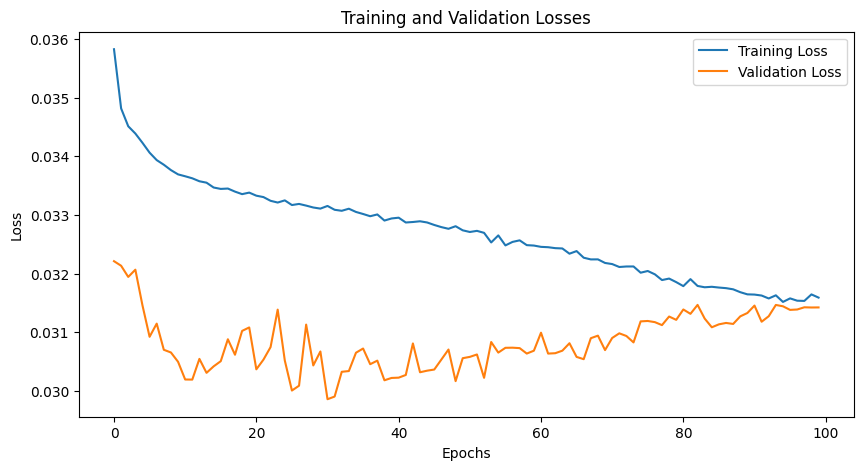

In [46]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()